# Create publication quality figures for paper

## Setup

In [1]:
# Standard imports
import sys
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import time
import dill
import json
import os

from scipy.stats import pearsonr, spearmanr

import torch
from torch.autograd import Variable
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch import nn

import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display

from sklearn import metrics as skmetrics
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.cluster import AgglomerativeClustering

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from captum.attr import IntegratedGradients
from captum.attr import LayerConductance
from captum.attr import NeuronConductance

In /home/krzysztof/anaconda3/envs/modeling_drug_efficacy/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
In /home/krzysztof/anaconda3/envs/modeling_drug_efficacy/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/krzysztof/anaconda3/envs/modeling_drug_efficacy/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The pgf.debug rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
In /home/krzysztof/anaconda3/envs/modeling_drug_efficacy/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/krzysztof/anaconda3/envs/modeling_drug_efficacy/lib/python3.6/site-packages/matplotl

In [2]:
# Custom utilities imports
sys.path.append("/media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Recommender System Approach/Scripts/Modules")
from modeling import Dataset, Results, Model, ModelWithAutoencoders, ModelAnalysis
import architectures

#### Load and prepare the dataset

In [3]:
# Load dataset
filepath = "../../Data/Preprocessed Datasets/"
with open(filepath + "GDSC-KINOMEscan_proteins_intersection_+_remaining_GDSC_target_genes_dataset_with_IC50.pkl", "rb") as f:
    full_dataset = dill.load(f)
print(full_dataset.name, type(full_dataset))
print()
print(full_dataset.description)
print(full_dataset.full_cell_lines_data.shape, full_dataset.drugs_data.shape)

Kinases Dataset + Remaning GDSC drug's putative targets <class 'modeling.Dataset'>

Dataset containing 74 common drugs of GDSC and HMS LINCS Kinome scan dataset.
Cell lines data types: expression, coding variant and tissue type. Expressions and coding variants are 
present only for proteins present in both GDSC and KINOMEscan data, resulting in expression of 188 genes and
nmutations in 18 genes.
In addition, expressions and mutations (17 new features) of remaining target genes from GDSC are included
Tissue types are dummy encoded GDSC Tissue Descriptions 1 (18 features).
Drugs representation: inhibition scores (% control) of 294 proteins. Set of proteins is the intersection of 
proteins screened for each of 74 drugs.
Drug response data: drug reponse data contains AUC metrics across cell lines for 74 drugs considered.
(922, 242) (74, 294)


#### Preprocess and extract data for the model trained on a whole data

In [4]:
# Preprocess
# Establish response data for samples (drug-cell line pairs)
general_response_df = full_dataset.response_data.copy()

# Establish cell line features data
cell_line_data_original_df = full_dataset.full_cell_lines_data.copy()

# Search for cell lines present in response data, but missing the genomic features
missing_cell_lines = []
for cosmic_id in general_response_df.COSMIC_ID.unique():
    if cosmic_id not in cell_line_data_original_df.cell_line_id.unique():
        missing_cell_lines.append(cosmic_id)
# Put cell line IDs into index and drop cell line IDs columns
cell_line_data_original_df.index = cell_line_data_original_df.cell_line_id
cell_line_data_original_df = cell_line_data_original_df.drop("cell_line_id", axis=1)

# Extract response only for cell lines for which features are present
general_response_df = general_response_df[~general_response_df.COSMIC_ID.isin(missing_cell_lines)]

# Establish drug features data
drug_data_original_df = full_dataset.drugs_data.copy()

# Convert drug index from LINCS name to GDSC drug ID
drug_data_original_df.index = drug_data_original_df.index.map(full_dataset.kinomescan_name_to_gdsc_id_mapper)

In [5]:
# Preprocess whole data for interpretability analysis purposes
global_response_metric = "LN_IC50"
# Create a set of all available samples
samples_all = general_response_df[["DRUG_ID", "COSMIC_ID", global_response_metric]]
# Scale the response variable if needed
samples_all[global_response_metric] = Dataset.min_max_series(samples_all[global_response_metric])
# Normalize the drug and cell line data
cols_subset = [col for col in list(cell_line_data_original_df) if col.endswith("_exp")]
cell_line_data_df = Dataset.standardize_data(cell_line_data_original_df, cols_subset=cols_subset)
# Drug data
drug_data_df = Dataset.standardize_data(drug_data_original_df)
print(samples_all.shape, cell_line_data_df.shape, drug_data_df.shape)

/home/krzysztof/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


(52730, 3) (922, 241) (74, 294)


# Figures

BMC:
- Half page width: 85 mm
- Full page width: 170 mm
- 300
- Max height: 225 mm
- One inch: 25.4 mm
- 170 mm corresponds to 6.6929133858 inches

In [6]:
full_page_figure_width_mm = 170
mm_per_inch = 25.4
global_dpi = 300
panels_filepath = "./BMC/Panels/"
global_axis_label_font_size = 9
retrained_model_dir = "../Final results/Models retrained on the whole data/One-layer autoencoders, two-layer code forwarding, with data augmentation, MinMaxScaled IC50 - params from experiment 4 - replay/"

In [7]:
! ls "./BMC/Panels/"

'Fig1 Overview'
 Fig2-cell_lines_clustermap_half_page.pdf
 Fig2-cell_lines_clustermap.pdf
 Fig2-drugs_clustermap_half_page.pdf
 Fig2-drugs_clustermap.pdf
'Fig3 GO terms lists'
 Fig3_GO_Biological_Process_2018_enrich_heatmap_after_revigo.pdf
 Fig3_GO_Biological_Process_2018_enrich_heatmap_after_revigo_sorted.pdf
 Fig3_GO_Biological_Process_2018_enrich_heatmap_after_revigo_unsorted.pdf
 Fig3_GO_Biological_Process_2018_enrich_heatmap.pdf
'Fig4 Drug cases'
 Fig5-drugs-process_clustermap_bi_clustering.pdf
 Fig5-drugs-process_clustermap_only_row_clustering.pdf
 FigS2_cov_cl_no_penalty.pdf
 FigS2_cov_cl_with_penalty.pdf
 FigS2_cov_drugs_no_penalty.pdf
 FigS2_cov_drugs_with_penalty.pdf


## Figure 1: Overview

#### Panels settings

In [8]:
# Set up constants
# Size in milimeters
panel_width_mm = 85
panel_height_mm = 75

# Size in inches
panel_width_inch = panel_width_mm / mm_per_inch
panel_height_inch = panel_height_mm / mm_per_inch

print("Width:", panel_width_mm, panel_width_inch)
print("Height:", panel_height_mm, panel_height_inch)

# Update rcParams
params = {
        'figure.figsize'      : [panel_width_inch, panel_height_inch] ,
        'font.size'           : 10      ,
        #'font.sans-serif'     : 'Arial'    ,
        'axes.titlesize'      : 12.       ,
        'axes.labelsize'      : 9.       ,
        'xtick.major.size'    : 2        ,
        'xtick.major.width'   : 0.75     ,
        'xtick.labelsize'     : 10.0      ,
        'xtick.direction'     : 'out'      ,
        'ytick.major.size'    : 2        ,
        'ytick.major.width'   : 0.75     ,
        'ytick.labelsize'     : 10.0      ,
        'ytick.direction'     : 'out'      ,
        'xtick.major.pad'     : 2        ,
        'xtick.minor.pad'     : 2        ,
        'ytick.major.pad'     : 2        ,
        'ytick.minor.pad'     : 2        ,
        'savefig.dpi'         : 350.      ,
        'axes.linewidth'      : 0.75     ,
        'text.usetex'         : False     ,
        'text.latex.unicode'  : False     }

Width: 85 3.346456692913386
Height: 75 2.952755905511811


#### Establish figure sizes

In [8]:
(4 / 6) * 50

33.33333333333333

In [41]:
cl_input_width = 28 / mm_per_inch
cl_input_height = 24 / mm_per_inch
dr_input_width = cl_input_height
dr_input_height = 22 / mm_per_inch
cl_latent_width = cl_input_width
cl_latent_height = 5 / mm_per_inch
dr_latent_width = cl_latent_height
dr_latent_height = dr_input_height
resp_width = cl_latent_width
resp_height = dr_input_height

#### Cell line input

In [42]:
# Create a DataFrame for heatmap

In [43]:
def create_heatmap_for_cl_feats(num_cont, num_cv, num_tiss, num_samples):
    heatmap_arr = np.zeros(shape=(num_cont + num_cv + num_tiss, num_samples))
    for i in range(num_tiss):
        place = np.random.randint(0, num_samples)
        vec = [0] * num_samples
        vec[place] = 1
        heatmap_arr[i] = vec
    for i in range(num_tiss, num_tiss + num_cv):
        places = np.random.randint(0, num_samples, size=2)
        vec = [0] * num_samples
        vec[places[0]] = 1
        vec[places[1]] = 1
        heatmap_arr[i] = vec
    for i in range(num_tiss + num_cv, num_tiss + num_cv + num_cont):
        vec = np.random.random(size=num_samples)
        heatmap_arr[i] = vec
    return heatmap_arr

In [44]:
m = create_heatmap_for_cl_feats(4, 3, 2, 10)
print(m.shape)

(9, 10)


In [45]:
os.path.join(panels_filepath)

'./BMC/Panels/'

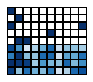

In [46]:
# create colormap. We take 101 values equally spaced between 0 and 1
# hence the first value 0, second value 0.01
c = np.linspace(0,1,101)
# For those values we store the colors from the "YlOrRd" map in an array
colors = plt.get_cmap("Blues",101)(c)
# We replace the first row of that array, by white
colors[0,:] = np.array([1,1,1,1])
# We create a new colormap with the colors
cmap = matplotlib.colors.ListedColormap(colors)


plt.figure(figsize=(cl_input_width, cl_input_height))

sns.heatmap(m, cmap=cmap, cbar=False, linewidths=0.5, linecolor="black", square=False)

plt.axis('off')

plt.tight_layout(pad=0)
plt.savefig(os.path.join(panels_filepath, "Fig1 Overview", "Fig1_overview_cl_input.pdf"))
plt.show()

#### Drug features

In [47]:
def create_heatmap_for_drug_feats(num_cont, num_samples):
    heatmap_arr = np.random.rand(num_samples, num_cont)
    return heatmap_arr

In [48]:
m = create_heatmap_for_drug_feats(8, 7)
m.shape

(7, 8)

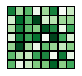

In [49]:
fig = plt.figure(figsize=(dr_input_width, dr_input_height))

sns.heatmap(m, cmap="Greens", cbar=False, linewidths=0.5, linecolor="black", square=False)

plt.axis('off')
plt.tight_layout(pad=0)
plt.savefig(os.path.join(panels_filepath, "Fig1 Overview", "Fig1_overview_drug_input.pdf"))
plt.show()

In [50]:
dr_input_height * mm_per_inch

22.0

#### Latent representation cl

In [51]:
m = create_heatmap_for_drug_feats(10, 2)
m.shape

(2, 10)

In [52]:
plt.figure(figsize=(cl_latent_width, cl_latent_height))

sns.heatmap(m, cmap="Purples", cbar=False, linewidths=0.5, linecolor="black", square=False)

plt.axis('off')

plt.tight_layout(pad=0)
plt.savefig(os.path.join(panels_filepath, "Fig1 Overview", "Fig1_overview_cl_latent.pdf"))
plt.show()

#### Latent representation drugs

In [53]:
m = create_heatmap_for_drug_feats(2, 7)
m.shape

(7, 2)

In [54]:
plt.figure(figsize=(dr_latent_width, dr_latent_height))

sns.heatmap(m, cmap="Purples", cbar=False, linewidths=0.5, linecolor="black", square=False)

plt.axis('off')

plt.tight_layout(pad=0)
plt.savefig(os.path.join(panels_filepath, "Fig1 Overview", "Fig1_overview_drug_latent.pdf"))
plt.show()

#### Response matrix

In [55]:
m = create_heatmap_for_drug_feats(10, 7)
m.shape

(7, 10)

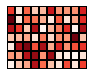

In [56]:
plt.figure(figsize=(resp_width, resp_height))

sns.heatmap(m, cmap="Reds", cbar=False, linewidths=1, linecolor="black")

plt.axis('off')

plt.tight_layout(pad=0)
plt.savefig(os.path.join(panels_filepath, "Fig1 Overview", "Fig1_overview_response_matrix.pdf"))
plt.show()

## Figure 2: covariance matrices (Supplementary)

### Load model retrained on the whole data

In [22]:
! ls "../Final results/Models retrained on the whole data/One-layer autoencoders, two-layer code forwarding, with data augmentation, MinMaxScaled IC50 - params from experiment 4 - replay/" | grep .pkl

retrained_model_all_cl_feats_scaled.pkl
retrained_model.pkl
retrained_without_augmentation.pkl
retrained_without_independence_loss.pkl


In [23]:
# Establish filepath to the experiment
model_dir = "../Final results/Models retrained on the whole data/One-layer autoencoders, two-layer code forwarding, with data augmentation, MinMaxScaled IC50 - params from experiment 4 - replay/"

In [26]:
# Load model trained with and without independence loss
with open(os.path.join(model_dir, "retrained_model.pkl"), "rb") as f:
    model_with_independence = dill.load(f)
    
with open(os.path.join(model_dir, "retrained_without_independence_loss.pkl"), "rb") as f:
    model_without_independence = dill.load(f)
print(type(model_with_independence), type(model_without_independence))
network_with_independence = model_with_independence.network
network_without_independence = model_without_independence.network

print(next(network_with_independence.parameters()).sum(), next(network_without_independence.parameters()).sum())

<class 'modeling.ModelWithAutoencoders'> <class 'modeling.ModelWithAutoencoders'>
tensor(27.6014, grad_fn=<SumBackward0>) tensor(50.9607, grad_fn=<SumBackward0>)


### Compute covariance matrices - model without penalty

In [28]:
network_without_independence.eval()

RecSystemCodeConcatenation(
  (drug_autoencoder): DeepAutoencoderOneHiddenLayer(
    (encoder): Sequential(
      (0): Linear(in_features=294, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=10, bias=True)
    )
    (decoder): Sequential(
      (0): Linear(in_features=10, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=294, bias=True)
    )
  )
  (cell_line_autoencoder): DeepAutoencoderOneHiddenLayer(
    (encoder): Sequential(
      (0): Linear(in_features=241, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=10, bias=True)
    )
    (decoder): Sequential(
      (0): Linear(in_features=10, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=241, bias=True)
    )
  )
  (forward_network): ForwardNetworkTwoHiddenLayers(
    (layers): Sequential(
      (0): Linear(in_features=20, out_features=512, bias=True)


In [29]:
# Compute reconstructions for drugs
drug_codes, drug_recs = network_without_independence.drug_autoencoder(torch.from_numpy(drug_data_df.values).float())
print(drug_codes.shape, drug_recs.shape)
# Create a DataFrame with drugs and their code embeddings
drug_codes_df = pd.DataFrame(drug_codes.detach().numpy(), index=drug_data_df.index)
print(drug_codes_df.shape)

# Compute reconstructions for all cell lines
cl_codes, cl_recs = network_without_independence.cell_line_autoencoder(torch.from_numpy(
    cell_line_data_df.values).float())
print(cl_codes.shape, cl_recs.shape)
cl_codes_df = pd.DataFrame(cl_codes.detach().numpy(), index=cell_line_data_df.index)
print(cl_codes_df.shape)

# Compute covariance matrices for drug and cell lines code representations
drug_codes_cov_no_penalty = np.cov(drug_codes.detach().numpy(), rowvar=False)
cl_codes_cov_no_penalty = np.cov(cl_codes.detach().numpy(), rowvar=False)
print(drug_codes_cov_no_penalty.shape, drug_codes_cov_no_penalty.shape)

torch.Size([74, 10]) torch.Size([74, 294])
(74, 10)
torch.Size([922, 10]) torch.Size([922, 241])
(922, 10)
(10, 10) (10, 10)


### Compute covariance matrices - model with penalty

In [30]:
# Compute reconstructions for drugs
drug_codes, drug_recs = network_with_independence.drug_autoencoder(torch.from_numpy(drug_data_df.values).float())
print(drug_codes.shape, drug_recs.shape)
# Create a DataFrame with drugs and their code embeddings
drug_codes_df = pd.DataFrame(drug_codes.detach().numpy(), index=drug_data_df.index)
print(drug_codes_df.shape)

# Compute reconstructions for all cell lines
cl_codes, cl_recs = network_with_independence.cell_line_autoencoder(torch.from_numpy(
    cell_line_data_df.values).float())
print(cl_codes.shape, cl_recs.shape)
cl_codes_df = pd.DataFrame(cl_codes.detach().numpy(), index=cell_line_data_df.index)
print(cl_codes_df.shape)

# Compute covariance matrices for drug and cell lines code representations
drug_codes_cov_with_penalty = np.cov(drug_codes.detach().numpy(), rowvar=False)
cl_codes_cov_with_penalty = np.cov(cl_codes.detach().numpy(), rowvar=False)
print(drug_codes_cov_with_penalty.shape, drug_codes_cov_with_penalty.shape)

torch.Size([74, 10]) torch.Size([74, 294])
(74, 10)
torch.Size([922, 10]) torch.Size([922, 241])
(922, 10)
(10, 10) (10, 10)


### Plot the covariance matrices

#### Setup the plotting parameters

In [31]:
170 / 4

42.5

In [83]:
# Set up constants
# Size in milimeters
panel_width_mm = 42.5
panel_height_mm = 40

# Size in inches
panel_width_inch = panel_width_mm / mm_per_inch
panel_height_inch = panel_height_mm / mm_per_inch

print("Width:", panel_width_mm, panel_width_inch)
print("Height:", panel_height_mm, panel_height_inch)

# Update rcParams
params = {
        'figure.figsize'      : [panel_width_inch, panel_height_inch] ,
        'font.size'           : 10      ,
        #'font.sans-serif'     : 'Arial'    ,
        'axes.titlesize'      : 12.       ,
        'axes.labelsize'      : 8.       ,
        'xtick.major.size'    : 2        ,
        'xtick.major.width'   : 0.75     ,
        'xtick.labelsize'     : 8.0      ,
        'xtick.direction'     : 'out'      ,
        'ytick.major.size'    : 2        ,
        'ytick.major.width'   : 0.75     ,
        'ytick.labelsize'     : 8.0      ,
        'ytick.direction'     : 'out'      ,
        'xtick.major.pad'     : 2        ,
        'xtick.minor.pad'     : 2        ,
        'ytick.major.pad'     : 2        ,
        'ytick.minor.pad'     : 2        ,
        'savefig.dpi'         : global_dpi      ,
        'axes.linewidth'      : 0.75     ,
        'text.usetex'         : False     ,
        'text.latex.unicode'  : False     }

Width: 42.5 1.673228346456693
Height: 40 1.5748031496062993


In [84]:
plt.rcParams.update(params)
print(plt.rcParams.get('figure.figsize'))
print(plt.rcParams.get('font.size'))

/home/krzysztof/anaconda3/envs/modeling_drug_efficacy/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]


[1.673228346456693, 1.5748031496062993]
10.0


In [85]:
# Update rcParams so that they can use Latex
plt.rcParams.update({"text.usetex": True})

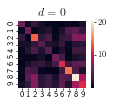

In [88]:
# Drugs with no penalty
plt.title(r"$d = 0$")
sns.heatmap(np.abs(drug_codes_cov_no_penalty), annot=False, xticklabels=True, 
            yticklabels=True)

plt.tight_layout()
plt.savefig(os.path.join(panels_filepath, "FigS2_cov_drugs_no_penalty.pdf"))
plt.show()

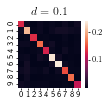

In [90]:
# Drugs with penalty
plt.title(r"$d = 0.1$")
sns.heatmap(np.abs(drug_codes_cov_with_penalty), annot=False, xticklabels=True, 
            yticklabels=True)

plt.tight_layout()
plt.savefig(os.path.join(panels_filepath, "FigS2_cov_drugs_with_penalty.pdf"))
plt.show()

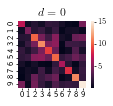

In [92]:
# Cell lines with no penalty
plt.title(r"$d = 0$")
sns.heatmap(np.abs(cl_codes_cov_no_penalty), annot=False, xticklabels=True, 
            yticklabels=True)

plt.tight_layout()
plt.savefig(os.path.join(panels_filepath, "FigS2_cov_cl_no_penalty.pdf"))
plt.show()

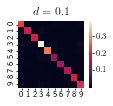

In [94]:
# Cell lines with penalty
plt.title(r"$d = 0.1$")
sns.heatmap(np.abs(cl_codes_cov_with_penalty), annot=False, xticklabels=True, 
            yticklabels=True)

plt.tight_layout()
plt.savefig(os.path.join(panels_filepath, "FigS2_cov_cl_with_penalty.pdf"))
plt.show()

## Figure 2: clustering heatmaps with neural network analysis

### Load the model retrained on whole data

In [8]:
! ls "../Final results/Models retrained on the whole data/One-layer autoencoders, two-layer code forwarding, with data augmentation, MinMaxScaled IC50 - params from experiment 4 - replay/" | grep .pkl

retrained_model_all_cl_feats_scaled.pkl
retrained_model.pkl
retrained_without_augmentation.pkl
retrained_without_independence_loss.pkl


In [9]:
# Establish filepath to the experiment
model_dir = "../Final results/Models retrained on the whole data/One-layer autoencoders, two-layer code forwarding, with data augmentation, MinMaxScaled IC50 - params from experiment 4 - replay/"

In [10]:
# Load model trained with independence loss
with open(os.path.join(model_dir, "retrained_model.pkl"), "rb") as f:
    retrained_model = dill.load(f)
retrained_network = retrained_model.network
print(type(retrained_model), type(retrained_network))
retrained_network.eval()

<class 'modeling.ModelWithAutoencoders'> <class 'architectures.RecSystemCodeConcatenation'>


RecSystemCodeConcatenation(
  (drug_autoencoder): DeepAutoencoderOneHiddenLayer(
    (encoder): Sequential(
      (0): Linear(in_features=294, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=10, bias=True)
    )
    (decoder): Sequential(
      (0): Linear(in_features=10, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=294, bias=True)
    )
  )
  (cell_line_autoencoder): DeepAutoencoderOneHiddenLayer(
    (encoder): Sequential(
      (0): Linear(in_features=241, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=10, bias=True)
    )
    (decoder): Sequential(
      (0): Linear(in_features=10, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=241, bias=True)
    )
  )
  (forward_network): ForwardNetworkTwoHiddenLayers(
    (layers): Sequential(
      (0): Linear(in_features=20, out_features=512, bias=True)


### Compute drug-code attributions heatmap

In [11]:
# Display clustered heatmap of feature-code attributions - drugs
def net(drug_input):
    return retrained_network.drug_autoencoder(drug_input)[0]
# For all drugs, heatmap if features vs. attributions
drug_input = torch.from_numpy(drug_data_df.values).float()
drug_input.requires_grad_()

# Method for calculating attributions
method = captum.attr.IntegratedGradients(net)

# Compute drug code attributions for every dimension in code space
drug_code_attributions_df = pd.DataFrame()
for dim in range(retrained_network.drug_autoencoder(drug_input[0])[0].shape[0]):
    code_attributions, delta = method.attribute(drug_input, target=dim,  return_convergence_delta=True)
    code_attributions = np.abs(code_attributions.detach().numpy())   # Take absolute value of the attributions
    code_attributions = np.mean(code_attributions, axis=0)
    drug_code_attributions_df[dim] = code_attributions
drug_code_attributions_df.index = drug_data_df.columns

# Normalize the data
index = drug_code_attributions_df.index
cols = drug_code_attributions_df.columns
drug_code_attributions_df = normalize(drug_code_attributions_df)
drug_code_attributions_df = pd.DataFrame(drug_code_attributions_df, index=index,
                                   columns=cols)
# Hierarchical clustering of the scaled heatmap - assign to clusters
num_clusters = 10
cluster = AgglomerativeClustering(n_clusters=num_clusters, affinity="euclidean", linkage="ward")
assignments = cluster.fit_predict(drug_code_attributions_df)

drug_code_attributions_df["cluster_assignment"] = assignments
drug_code_attributions_df = drug_code_attributions_df.sort_values("cluster_assignment")
# Create a dictionary mapping each cluster assignmnet to color
drug_color_dict = {}
palette = sns.color_palette(n_colors=num_clusters)
for cl, color in zip(drug_code_attributions_df.cluster_assignment.unique(), palette):
    drug_color_dict[cl] = color
drug_feat_color_map = {}
for feat, assign in zip(drug_code_attributions_df.index, drug_code_attributions_df.cluster_assignment):
    drug_feat_color_map[feat] = drug_color_dict[assign]

### Compute cell line-code attributions heatmap

In [12]:
def net(cl_input):
    return retrained_network.cell_line_autoencoder(cl_input)[0]
# For all drugs, heatmap if features vs. attributions
cl_input = torch.from_numpy(cell_line_data_df.values).float()
cl_input.requires_grad_()

# Method for calculating attributions
method = captum.attr.IntegratedGradients(net)

# Compute drug code attributions for every dimension in code space
cl_code_attributions_df = pd.DataFrame()
for dim in range(retrained_network.cell_line_autoencoder(cl_input[0])[0].shape[0]):
    code_attributions, delta = method.attribute(cl_input, target=dim,  return_convergence_delta=True)
    code_attributions = np.abs(code_attributions.detach().numpy())   # Take absolute value of the attributions
    code_attributions = np.mean(code_attributions, axis=0)
    cl_code_attributions_df[dim] = code_attributions

cl_code_attributions_df.index = cell_line_data_df.columns
# Normalize the data
index = cl_code_attributions_df.index
cols = cl_code_attributions_df.columns
cl_code_attributions_df = normalize(cl_code_attributions_df)
cl_code_attributions_df = pd.DataFrame(cl_code_attributions_df, index=index,
                                   columns=cols)

# Hierarchical clustering of the scaled heatmap - assign to clusters
num_clusters = 10
cluster = AgglomerativeClustering(n_clusters=num_clusters, affinity="euclidean", linkage="ward")
assignments = cluster.fit_predict(cl_code_attributions_df)

cl_code_attributions_df["cluster_assignment"] = assignments
cl_code_attributions_df = cl_code_attributions_df.sort_values("cluster_assignment")
# Create a dictionary mapping each cluster assignmnet to color
cl_color_dict = {}
palette = sns.color_palette(n_colors=num_clusters)
for cl, color in zip(cl_code_attributions_df.cluster_assignment.unique(), palette):
    cl_color_dict[cl] = color
cl_feat_color_map = {}
for feat, assign in zip(cl_code_attributions_df.index, cl_code_attributions_df.cluster_assignment):
    cl_feat_color_map[feat] = cl_color_dict[assign]

### Plot the clustermaps - full page width, without feature names

#### Setup plotting parameters

In [47]:
full_page_figure_width_mm / 2

85.0

In [66]:
# Set up constants
# Size in milimeters
panel_width_mm = full_page_figure_width_mm / 2
panel_height_mm = 80

# Size in inches
panel_width_inch = panel_width_mm / mm_per_inch
panel_height_inch = panel_height_mm / mm_per_inch

print("Width:", panel_width_mm, panel_width_inch)
print("Height:", panel_height_mm, panel_height_inch)

# Update rcParams
params = {
        'figure.figsize'      : [panel_width_inch, panel_height_inch] ,
        'font.size'           : 10      ,
        #'font.sans-serif'     : 'Arial'    ,
        'axes.titlesize'      : 12.       ,
        'axes.labelsize'      : 9.       ,
        'xtick.major.size'    : 2        ,
        'xtick.major.width'   : 0.75     ,
        'xtick.labelsize'     : 8.0      ,
        'xtick.direction'     : 'out'      ,
        'ytick.major.size'    : 2        ,
        'ytick.major.width'   : 0.75     ,
        'ytick.labelsize'     : 4.0      ,
        'ytick.direction'     : 'out'      ,
        'xtick.major.pad'     : 2        ,
        'xtick.minor.pad'     : 2        ,
        'ytick.major.pad'     : 2        ,
        'ytick.minor.pad'     : 2        ,
        'savefig.dpi'         : global_dpi      ,
        'axes.linewidth'      : 0.75     ,
        'text.usetex'         : False     ,
        'text.latex.unicode'  : False     }

Width: 85.0 3.346456692913386
Height: 80 3.1496062992125986


In [67]:
plt.rcParams.update(params)
print(plt.rcParams.get('figure.figsize'))
print(plt.rcParams.get('font.size'))

/home/krzysztof/anaconda3/envs/modeling_drug_efficacy/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]


[3.346456692913386, 3.1496062992125986]
10.0


#### Plot the drug full page clustermap

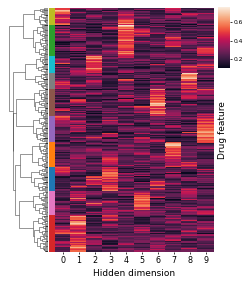

In [115]:
# Overwrite some plotting params
width = full_page_figure_width_mm / (2 * mm_per_inch)
height = 120 / mm_per_inch
axis_label_size = 9
cbar_tick_font_size = 6
title_size = 12

pos = (0.92, 0.61, 0.05, 0.18)
# Plot clustermap using seaborn
grid = sns.clustermap(drug_code_attributions_df.iloc[:, :-1], method="ward", metric="euclidean", row_linkage=None,
                      col_cluster=False, 
                      row_colors=[drug_feat_color_map[x] for x in drug_code_attributions_df.index], 
                      yticklabels=False, mask=None,
                      figsize=(width, height),
                      cbar_pos=pos,
                      cbar_kws={})
# Set heatmap params
#grid.ax_heatmap.set_title("Features-code attributions - drugs", fontsize=title_size)
grid.ax_heatmap.set_xlabel("Hidden dimension", fontsize=axis_label_size)
grid.ax_heatmap.set_ylabel("Drug feature", fontsize=axis_label_size)

# Modify colorbar and get rid of the gap at the top
#grid.cax.set_visible(False)
grid.cax.tick_params(labelsize=cbar_tick_font_size, rotation=0)
grid.ax_col_dendrogram.set_visible(False)

for ytick in grid.ax_heatmap.get_yticklabels():
    color = drug_feat_color_map[ytick._text]
    ytick.set_color(color)

grid.savefig(os.path.join(panels_filepath, "Fig2-drugs_clustermap.pdf"))
plt.show()

#### Plot the cell lines full page clustermap

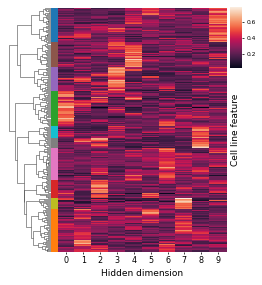

In [128]:
# Overwrite some plotting params
width = full_page_figure_width_mm / (2 * mm_per_inch)
height = 120 / mm_per_inch
axis_label_size = 9
cbar_tick_font_size = 6
title_size = 12

pos = (0.97, 0.61, 0.05, 0.18)
# Plot clustermap using seaborn
grid = sns.clustermap(cl_code_attributions_df.iloc[:, :-1], method="ward", metric="euclidean", row_linkage=None,
                      col_cluster=False, 
                      row_colors=[cl_feat_color_map[x] for x in cl_code_attributions_df.index], 
                      yticklabels=False, mask=None,
                      figsize=(width, height),
                      cbar_pos=pos,
                      cbar_kws={},
                      **{"cmap": None})
# Set heatmap params
#grid.ax_heatmap.set_title("Features-code attributions - drugs", fontsize=title_size)
grid.ax_heatmap.set_xlabel("Hidden dimension", fontsize=axis_label_size)
grid.ax_heatmap.set_ylabel("Cell line feature", fontsize=axis_label_size)

# Modify colorbar and get rid of the gap at the top
#grid.cax.set_visible(False)
grid.cax.tick_params(labelsize=cbar_tick_font_size, rotation=0)
grid.ax_col_dendrogram.set_visible(False)

for ytick in grid.ax_heatmap.get_yticklabels():
    color = cl_feat_color_map[ytick._text]
    ytick.set_color(color)

#grid.savefig(os.path.join(panels_filepath, "Fig2-cell_lines_clustermap.pdf"))
plt.show()

In [129]:
print(height * mm_per_inch, width * mm_per_inch)

120.0 85.0


### Plot the clustermaps - half page width, with feature names

#### Setup plotting parameters

In [62]:
# Set up constants
# Size in milimeters
panel_width_mm = full_page_figure_width_mm / 2
panel_height_mm = 80

# Size in inches
panel_width_inch = panel_width_mm / mm_per_inch
panel_height_inch = panel_height_mm / mm_per_inch

print("Width:", panel_width_mm, panel_width_inch)
print("Height:", panel_height_mm, panel_height_inch)

# Update rcParams
params = {
        'figure.figsize'      : [panel_width_inch, panel_height_inch] ,
        'font.size'           : 10      ,
        #'font.sans-serif'     : 'Arial'    ,
        'axes.titlesize'      : 12.       ,
        'axes.labelsize'      : 9.       ,
        'xtick.major.size'    : 2        ,
        'xtick.major.width'   : 0.75     ,
        'xtick.labelsize'     : 6.0      ,
        'xtick.direction'     : 'out'      ,
        'ytick.major.size'    : 2        ,
        'ytick.major.width'   : 0.75     ,
        'ytick.labelsize'     : 2.0      ,
        'ytick.direction'     : 'out'      ,
        'xtick.major.pad'     : 2        ,
        'xtick.minor.pad'     : 2        ,
        'ytick.major.pad'     : 2        ,
        'ytick.minor.pad'     : 2        ,
        'savefig.dpi'         : global_dpi      ,
        'axes.linewidth'      : 0.75     ,
        'text.usetex'         : False     ,
        'text.latex.unicode'  : False     }



Width: 85.0 3.346456692913386
Height: 80 3.1496062992125986


In [63]:
plt.rcParams.update(params)
print(plt.rcParams.get('figure.figsize'))
print(plt.rcParams.get('font.size'))

/home/krzysztof/anaconda3/envs/modeling_drug_efficacy/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]


[3.346456692913386, 3.1496062992125986]
10.0


#### Plot the drug half page clustermap

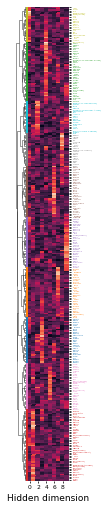

In [65]:
# Overwrite some plotting params
width = full_page_figure_width_mm / (4 * mm_per_inch)
height = 220 / mm_per_inch
axis_label_size = 9
cbar_tick_font_size = 6
title_size = 12

#pos = (0.92, 0.61, 0.05, 0.18)
# Plot clustermap using seaborn
grid = sns.clustermap(drug_code_attributions_df.iloc[:, :-1], method="ward", metric="euclidean", row_linkage=None,
                      col_cluster=False, 
                      row_colors=[drug_feat_color_map[x] for x in drug_code_attributions_df.index], 
                      yticklabels=True, mask=None,
                      figsize=(width, height),
                      cbar_kws={})
# Set heatmap params
#grid.ax_heatmap.set_title("Features-code attributions - drugs", fontsize=title_size)
grid.ax_heatmap.set_xlabel("Hidden dimension", fontsize=axis_label_size)
grid.ax_heatmap.set_ylabel("", fontsize=axis_label_size)

# Modify colorbar and get rid of the gap at the top
grid.cax.set_visible(False)
grid.cax.tick_params(labelsize=cbar_tick_font_size, rotation=0)
grid.ax_col_dendrogram.set_visible(False)

for ytick in grid.ax_heatmap.get_yticklabels():
    color = drug_feat_color_map[ytick._text]
    ytick.set_color(color)

grid.savefig(os.path.join(panels_filepath, "Fig2-drugs_clustermap_half_page.pdf"))
plt.show()

In [66]:
height * mm_per_inch

220.0

#### Plot the cell lines half page clustermap

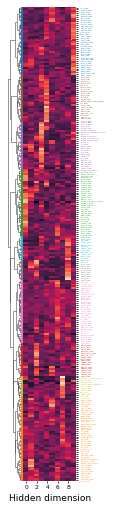

In [68]:
# Overwrite some plotting params
width = full_page_figure_width_mm / (4 * mm_per_inch)
height = 220 / mm_per_inch
axis_label_size = 9
cbar_tick_font_size = 6
title_size = 12

pos = (0.97, 0.61, 0.05, 0.18)
# Plot clustermap using seaborn
grid = sns.clustermap(cl_code_attributions_df.iloc[:, :-1], method="ward", metric="euclidean", row_linkage=None,
                      col_cluster=False, 
                      row_colors=[cl_feat_color_map[x] for x in cl_code_attributions_df.index], 
                      yticklabels=True, mask=None,
                      figsize=(width, height),
                      cbar_pos=pos,
                      cbar_kws={},
                      **{"cmap": None})
# Set heatmap params
#grid.ax_heatmap.set_title("Features-code attributions - drugs", fontsize=title_size)
grid.ax_heatmap.set_xlabel("Hidden dimension", fontsize=axis_label_size)
grid.ax_heatmap.set_ylabel("", fontsize=axis_label_size)

# Modify colorbar and get rid of the gap at the top
grid.cax.set_visible(False)
grid.cax.tick_params(labelsize=cbar_tick_font_size, rotation=0)
grid.ax_col_dendrogram.set_visible(False)

for ytick in grid.ax_heatmap.get_yticklabels():
    color = cl_feat_color_map[ytick._text]
    ytick.set_color(color)

grid.savefig(os.path.join(panels_filepath, "Fig2-cell_lines_clustermap_half_page.pdf"))
plt.show()

### Create tables with dimension - features assignments

#### Drugs

In [39]:
drug_code_attributions_df.head(2)

,0,1,2,3,4,5,6,7,8,9,cluster_assignment
Protein,,,,,,,,,,,
MAPKAPK2,0.149216,0.153277,0.492358,0.536482,0.380046,0.125098,0.195718,0.339528,0.173885,0.28303,0
CHEK1,0.466494,0.213727,0.293315,0.492570,0.228641,0.144891,0.203728,0.219435,0.228484,0.43922,0


In [40]:
cluster_dim_dict = {}
length = drug_code_attributions_df.cluster_assignment.value_counts().max()
features_dimension_df = pd.DataFrame()
for cluster in drug_code_attributions_df.cluster_assignment.unique():
    df = drug_code_attributions_df[
        drug_code_attributions_df.cluster_assignment == cluster
    ]
    df.insert(0, "Feature", df.index)
    # Establish which dimension corresponds to this cluster
    dimension = df.drop(["Feature", "cluster_assignment"], axis=1).sum().idxmax()
    cluster_dim_dict[cluster] = dimension
    df = df[["Feature", dimension, "cluster_assignment"]]
    df = df.sort_values(dimension, ascending=False)
    top_feats = list(df["Feature"])
    top_feats = top_feats + [np.nan] * (length - len(top_feats))
    features_dimension_df[cluster] = top_feats
print(features_dimension_df.shape)
features_dimension_df.head(3)

(44, 10)


,0,1,2,3,4,5,6,7,8,9
0,ERK5,TLK2,M4K1,FER,DCAMKL3,JNK3,PIK3CA(E545K),INSRR,EGFR(G719S),PAK3
1,BRSK1,MLCK,MERTK,NUAK1,PGFRB,LATS2,LKB1,RIPK2,EGFR(L858R),AKT2
2,PIM2,TGFBR1,RET,KIT(D816V),PAK2,CSNK2A2,EGFR,PAK4,LYN,"EGFR(L747-T751del,Sins)"


In [41]:
cluster_dim_dict

{0: 3, 1: 7, 2: 4, 3: 1, 4: 9, 5: 6, 6: 5, 7: 8, 8: 0, 9: 2}

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


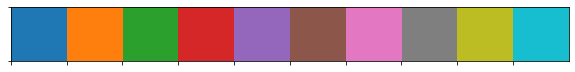

In [42]:
clusters = []
colors = []
for cluster, color in drug_color_dict.items():
    clusters.append(cluster)
    colors.append(color)
print(clusters)
sns.palplot(colors)

In [43]:
features_dimension_df = features_dimension_df.rename(columns=cluster_dim_dict)
features_dimension_df.head()

,3,7,4,1,9,6,5,8,0,2
0,ERK5,TLK2,M4K1,FER,DCAMKL3,JNK3,PIK3CA(E545K),INSRR,EGFR(G719S),PAK3
1,BRSK1,MLCK,MERTK,NUAK1,PGFRB,LATS2,LKB1,RIPK2,EGFR(L858R),AKT2
2,PIM2,TGFBR1,RET,KIT(D816V),PAK2,CSNK2A2,EGFR,PAK4,LYN,"EGFR(L747-T751del,Sins)"
3,TYRO3,KCC2D,KPCD3,CAMK2G,CSNK1E,DDR1,MARK2,M3K5,FLT3(N841I),SYK
4,PLK1,ACVR2A,MKNK1,FGFR4,KPCD2,CDK11,MLK2,ACVR2B,PIP5K1A,SRMS


In [44]:
features_dimension_df = features_dimension_df[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]
features_dimension_df.head(2)

,0,1,2,3,4,5,6,7,8,9
0,EGFR(G719S),FER,PAK3,ERK5,M4K1,PIK3CA(E545K),JNK3,TLK2,INSRR,DCAMKL3
1,EGFR(L858R),NUAK1,AKT2,BRSK1,MERTK,LKB1,LATS2,MLCK,RIPK2,PGFRB


In [45]:
model_dir

'../Final results/Models retrained on the whole data/One-layer autoencoders, two-layer code forwarding, with data augmentation, MinMaxScaled IC50 - params from experiment 4 - replay/'

In [48]:
! ls "../Final results/Models retrained on the whole data/One-layer autoencoders, two-layer code forwarding, with data augmentation, MinMaxScaled IC50 - params from experiment 4 - replay/"

'Gene set enrichment analysis'
 network_all_cl_feats_scaled_state_dict.pth
 network_state_dict.pth
 network_without_augmentation_state_dict.pth
 network_without_independence_loss_state_dict.pth
'Preprocessed results'
 retrained_model_all_cl_feats_scaled.pkl
 retrained_model.pkl
 retrained_without_augmentation.pkl
 retrained_without_independence_loss.pkl
 specifications.json


In [55]:
# Save the table
features_dimension_df.fillna("-").to_csv(os.path.join(model_dir, "Preprocessed results", "drugs_dim_feat_grouping_integrated_gradients.csv"),
                                        index=False)

#### Cell lines

In [56]:
cl_code_attributions_df.head(2)

,0,1,2,3,4,5,6,7,8,9,cluster_assignment
Tissue_bone,0.451012,0.482101,0.253349,0.217650,0.103635,0.314637,0.151029,0.138898,0.126647,0.533602,0
ACVR1B_mut,0.167574,0.287005,0.387771,0.318594,0.262093,0.293009,0.160637,0.260079,0.269794,0.562937,0


In [57]:
cluster_dim_dict = {}
length = cl_code_attributions_df.cluster_assignment.value_counts().max()
features_dimension_df = pd.DataFrame()
for cluster in cl_code_attributions_df.cluster_assignment.unique():
    df = cl_code_attributions_df[
        cl_code_attributions_df.cluster_assignment == cluster
    ]
    df.insert(0, "Feature", df.index)
    # Establish which dimension corresponds to this cluster
    dimension = df.drop(["Feature", "cluster_assignment"], axis=1).sum().idxmax()
    cluster_dim_dict[cluster] = dimension
    df = df[["Feature", dimension, "cluster_assignment"]]
    df = df.sort_values(dimension, ascending=False)
    top_feats = list(df["Feature"])
    top_feats = top_feats + [np.nan] * (length - len(top_feats))
    features_dimension_df[cluster] = top_feats
print(features_dimension_df.shape)
C.head(3)

(42, 10)


,0,1,2,3,4,5,6,7,8,9
0,MKNK2_exp,FLT3_exp,TGFBR2_mut,CHEK1_exp,CSK_exp,BMX_exp,ALK_exp,MELK_exp,Tissue_neuroblastoma,BRAF_mut
1,EPHA3_exp,CSNK1G3_exp,FGFR1_exp,MAP3K4_exp,PLK2_exp,DAPK2_exp,STK33_exp,TTK_exp,Tissue_large_intestine,ITK_exp
2,CSNK1D_exp,MARK2_exp,Tissue_nervous_system,MERTK_exp,Tissue_urogenital_system,CLK2_exp,PHKG2_exp,PLK4_exp,EPHA2_mut,BMPR2_mut


{0: 9, 1: 1, 2: 0, 3: 2, 4: 3, 5: 4, 6: 6, 7: 8, 8: 7, 9: 8}
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


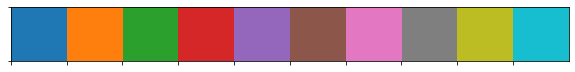

In [70]:
print(cluster_dim_dict)
clusters = []
colors = []
for cluster, color in cl_color_dict.items():
    clusters.append(cluster)
    colors.append(color)
print(clusters)
sns.palplot(colors)

In [79]:
print(features_dimension_df.shape[0] - features_dimension_df[7].isnull().sum(),
      features_dimension_df.shape[0] - features_dimension_df[9].isnull().sum())

10 12


In [80]:
# Merge clusters 7 and 9
features_dimension_df[7] = list(features_dimension_df[7].iloc[:10]) + list(features_dimension_df[9].iloc[:12]) + [np.nan] * 20

In [82]:
# Drop dimension 9
features_dimension_df = features_dimension_df.drop(9, axis=1)
print(features_dimension_df.shape)

(42, 9)


In [83]:
features_dimension_df = features_dimension_df.rename(columns=cluster_dim_dict)
features_dimension_df.head()

,9,1,0,2,3,4,6,8,7
0,MKNK2_exp,FLT3_exp,TGFBR2_mut,CHEK1_exp,CSK_exp,BMX_exp,ALK_exp,MELK_exp,Tissue_neuroblastoma
1,EPHA3_exp,CSNK1G3_exp,FGFR1_exp,MAP3K4_exp,PLK2_exp,DAPK2_exp,STK33_exp,TTK_exp,Tissue_large_intestine
2,CSNK1D_exp,MARK2_exp,Tissue_nervous_system,MERTK_exp,Tissue_urogenital_system,CLK2_exp,PHKG2_exp,PLK4_exp,EPHA2_mut
3,SRMS_exp,EPHA4_mut,RIOK3_exp,MARK1_exp,DDR1_exp,MAP4K4_exp,CHEK2_mut,NEK2_exp,Tissue_lung
4,AKT1_mut,Tissue_lung_SCLC,MYLK_exp,NEK9_exp,MET_exp,AXL_exp,Tissue_breast,STK16_exp,ACVRL1_exp


In [84]:
features_dimension_df = features_dimension_df[[0, 1, 2, 3, 4, 6, 7, 8, 9]]
features_dimension_df.head(3)

,0,1,2,3,4,6,7,8,9
0,TGFBR2_mut,FLT3_exp,CHEK1_exp,CSK_exp,BMX_exp,ALK_exp,Tissue_neuroblastoma,MELK_exp,MKNK2_exp
1,FGFR1_exp,CSNK1G3_exp,MAP3K4_exp,PLK2_exp,DAPK2_exp,STK33_exp,Tissue_large_intestine,TTK_exp,EPHA3_exp
2,Tissue_nervous_system,MARK2_exp,MERTK_exp,Tissue_urogenital_system,CLK2_exp,PHKG2_exp,EPHA2_mut,PLK4_exp,CSNK1D_exp


In [85]:
# Save the table
features_dimension_df.fillna("-").to_csv(os.path.join(model_dir, "Preprocessed results", "cell_lines_dim_feat_grouping_integrated_gradients.csv"),
                                        index=False)

## Table: dimension - feature attributions based on code-input correlations

### Load model retrained on whole data

In [8]:
! ls "../Final results/Models retrained on the whole data/One-layer autoencoders, two-layer code forwarding, with data augmentation, MinMaxScaled IC50 - params from experiment 4 - replay/" | grep .pkl

retrained_model_all_cl_feats_scaled.pkl
retrained_model.pkl
retrained_without_augmentation.pkl
retrained_without_independence_loss.pkl


In [9]:
# Establish filepath to the experiment
model_dir = "../Final results/Models retrained on the whole data/One-layer autoencoders, two-layer code forwarding, with data augmentation, MinMaxScaled IC50 - params from experiment 4 - replay/"

In [10]:
# Load model trained with independence loss
with open(os.path.join(model_dir, "retrained_model.pkl"), "rb") as f:
    retrained_model = dill.load(f)
retrained_network = retrained_model.network
print(type(retrained_model), type(retrained_network))
retrained_network.eval()

<class 'modeling.ModelWithAutoencoders'> <class 'architectures.RecSystemCodeConcatenation'>


RecSystemCodeConcatenation(
  (drug_autoencoder): DeepAutoencoderOneHiddenLayer(
    (encoder): Sequential(
      (0): Linear(in_features=294, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=10, bias=True)
    )
    (decoder): Sequential(
      (0): Linear(in_features=10, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=294, bias=True)
    )
  )
  (cell_line_autoencoder): DeepAutoencoderOneHiddenLayer(
    (encoder): Sequential(
      (0): Linear(in_features=241, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=10, bias=True)
    )
    (decoder): Sequential(
      (0): Linear(in_features=10, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=241, bias=True)
    )
  )
  (forward_network): ForwardNetworkTwoHiddenLayers(
    (layers): Sequential(
      (0): Linear(in_features=20, out_features=512, bias=True)


### Compute the code-feat correlation tables

In [40]:
! ls "../Final results/Models retrained on the whole data/One-layer autoencoders, two-layer code forwarding, with data augmentation, MinMaxScaled IC50 - params from experiment 4 - replay/Gene set enrichment analysis/Cell lines"

 cell_lines_decoder_spearman_features_code_space_correlations.csv
 cell_lines_relevant_genes_in_dimension_0_top_10_neg_and_pos.txt
 cell_lines_relevant_genes_in_dimension_1_top_10_neg_and_pos.txt
 cell_lines_relevant_genes_in_dimension_2_top_10_neg_and_pos.txt
 cell_lines_relevant_genes_in_dimension_3_top_10_neg_and_pos.txt
 cell_lines_relevant_genes_in_dimension_4_top_10_neg_and_pos.txt
 cell_lines_relevant_genes_in_dimension_5_top_10_neg_and_pos.txt
 cell_lines_relevant_genes_in_dimension_6_top_10_neg_and_pos.txt
 cell_lines_relevant_genes_in_dimension_7_top_10_neg_and_pos.txt
 cell_lines_relevant_genes_in_dimension_8_top_10_neg_and_pos.txt
 cell_lines_relevant_genes_in_dimension_9_top_10_neg_and_pos.txt
'Correlations with features outside input data'
 DAVID
'GSEA preranked'


In [41]:
model_dir

'../Final results/Models retrained on the whole data/One-layer autoencoders, two-layer code forwarding, with data augmentation, MinMaxScaled IC50 - params from experiment 4 - replay/'

In [50]:
entities = "cell lines"
inputs = cell_line_data_df.copy()
autoencoder_part = "decoder"
corr_metric = "spearman"
absolute_corr = False
filename = None

corr_df = retrained_model.features_codes_corr_ranked_lists_instance(entities,
                                                inputs, autoencoder_part, corr_metric, 
                                                absolute_corr, filename=filename)
print(corr_df.shape)
corr_df.tail(3)

(241, 10)


,0,1,2,3,4,5,6,7,8,9
ATM_mut,0.144572,-0.080283,0.005272,-0.075835,-0.033959,0.111790,-0.008815,0.062244,0.042410,0.030746
CHEK2_mut,0.007354,0.017067,0.144051,0.028548,-0.170028,0.029169,-0.122469,-0.019435,-0.010861,0.036748
NTRK2_mut,0.069470,-0.008723,-0.000500,-0.014708,0.051107,0.167129,-0.047948,0.100402,-0.036186,-0.012647


In [51]:
# Save the correlation DataFrame

### Load the pre-computed code-feat correlation tables and preprocess

In [9]:
model_dir = "../Final results/Models retrained on the whole data/One-layer autoencoders, two-layer code forwarding, with data augmentation, MinMaxScaled IC50 - params from experiment 4 - replay/"

#### Drugs

In [10]:
os.listdir(os.path.join(model_dir, "Gene set enrichment analysis/Drugs"))

['drugs_decoder_spearman_features_code_space_correlations.csv', 'GSEA Prerank']

In [26]:
corr_df = pd.read_csv(os.path.join(model_dir, "Gene set enrichment analysis/Drugs", 
                                   "drugs_decoder_spearman_features_code_space_correlations.csv"), index_col=0)
print(corr_df.shape)
corr_df.head(3)

(294, 10)


,0,1,2,3,4,5,6,7,8,9
Protein,,,,,,,,,,
MAPKAPK2,-0.049508,-0.289004,0.043554,-0.188893,0.044472,-0.211196,0.080370,0.136261,-0.041807,0.098141
MARK1,0.007419,0.096720,0.070300,-0.040474,-0.247864,-0.384909,0.142332,-0.254469,-0.175831,-0.178941
CAMKK2,-0.420304,0.213210,0.194757,0.098882,-0.260363,-0.420896,0.193336,0.146064,-0.082295,-0.033899


In [27]:
# Create a DataFrame with top k mostly correlated features in every dimension (k most positively and k most negatively)
topk = 10
threshold = 0.2
corr_df_sorted = pd.DataFrame(columns=corr_df.columns)
for dim in corr_df.columns:
    df = corr_df[[dim]]
    df.insert(0, "Feature", df.index)
    # Sort values
    df = df.sort_values(dim, ascending=False)
    # Take top values
    df_tops = pd.concat((df.iloc[:topk], df.iloc[-topk:]), axis=0)
    # Extract just values above threshold
    df_tops = df_tops.where(abs(df_tops[dim]) > threshold)
    corr_df_sorted[dim] = list(df_tops["Feature"])

In [28]:
corr_df_sorted

,0,1,2,3,4,5,6,7,8,9
0,MK14,CSK,CDK2,GSK3A,AKT1,AKT3,CLK2,MLCK,FAK1,CSNK1D
1,RIOK3,YES,MST3,CDK16,PIK3CA(E545K),NaN,CLK4,CAMK2G,ALK,ADCK4
2,NaN,ALK,CAMK1G,PLK1,PIK3CA,NaN,CLK1,KCC2D,IGF1R,PKMYT1
3,NaN,EGFR(L861Q),TNNI3K,CDK9,AKT3,NaN,CAMK2A,PCTK3,FER,MK11
4,NaN,SLK,YSK1,CDK2,NaN,NaN,DYRK1B,PIM3,STK33,CSNK1E
5,NaN,EGFR(S752-I759del),PAK1,ERK8,NaN,NaN,AAK1,CAMK2B,PLK1,BMPR2
6,NaN,TIE2,YANK3,ERK5,NaN,NaN,CSNK1A1L,PAK2,INSRR,ADCK3
7,NaN,SRMS,EPHA3,PCTK2,NaN,NaN,MYLK,PIM1,LTK,AKT1
8,NaN,FER,LIMK1,CDK3,NaN,NaN,PIM1,CDK11,TNK2,ERK4
9,NaN,EGFR,EPHA8,PCTK3,NaN,NaN,KCC2D,AKT3,NaN,NEK5


In [29]:
# Save the resulting table
filename = "drugs_top_{}_feats_in_dims_spearman_decoder_{}_threshold.csv".format(topk, threshold)
corr_df_sorted.fillna("-").to_csv(os.path.join(model_dir, "Gene set enrichment analysis/Drugs", filename),
                     index=False)

#### Cell lines

In [30]:
os.listdir(os.path.join(model_dir, "Gene set enrichment analysis/Cell lines"))

['cell_lines_decoder_spearman_features_code_space_correlations.csv',
 'cell_lines_relevant_genes_in_dimension_0_top_10_neg_and_pos.txt',
 'cell_lines_relevant_genes_in_dimension_1_top_10_neg_and_pos.txt',
 'cell_lines_relevant_genes_in_dimension_2_top_10_neg_and_pos.txt',
 'cell_lines_relevant_genes_in_dimension_3_top_10_neg_and_pos.txt',
 'cell_lines_relevant_genes_in_dimension_4_top_10_neg_and_pos.txt',
 'cell_lines_relevant_genes_in_dimension_5_top_10_neg_and_pos.txt',
 'cell_lines_relevant_genes_in_dimension_6_top_10_neg_and_pos.txt',
 'cell_lines_relevant_genes_in_dimension_7_top_10_neg_and_pos.txt',
 'cell_lines_relevant_genes_in_dimension_8_top_10_neg_and_pos.txt',
 'cell_lines_relevant_genes_in_dimension_9_top_10_neg_and_pos.txt',
 'Correlations with features outside input data',
 'DAVID',
 'GSEA preranked']

In [31]:
corr_df = pd.read_csv(os.path.join(model_dir, "Gene set enrichment analysis/Cell lines", 
                                   "cell_lines_decoder_spearman_features_code_space_correlations.csv"), index_col=0)
print(corr_df.shape)
corr_df.head(3)

(241, 10)


,0,1,2,3,4,5,6,7,8,9
PRKX_exp,0.025094,0.058651,0.023422,0.376876,-0.409279,-0.150282,0.247405,0.134040,0.225134,0.108441
TIE1_exp,-0.072529,0.066015,0.066565,0.380376,-0.086262,-0.237869,-0.294830,0.062571,-0.043802,-0.367139
BMPR2_exp,-0.257703,-0.361432,-0.047378,-0.365835,0.374886,-0.071634,0.104974,-0.352715,0.080433,0.230805


In [32]:
# Create a DataFrame with top k mostly correlated features in every dimension (k most positively and k most negatively)
topk = 10
threshold = 0.2
corr_df_sorted = pd.DataFrame(columns=corr_df.columns)
for dim in corr_df.columns:
    df = corr_df[[dim]]
    df.insert(0, "Feature", df.index)
    # Sort values
    df = df.sort_values(dim, ascending=False)
    # Take top values
    df_tops = pd.concat((df.iloc[:topk], df.iloc[-topk:]), axis=0)
    # Extract just values above threshold
    df_tops = df_tops.where(abs(df_tops[dim]) > threshold)
    corr_df_sorted[dim] = list(df_tops["Feature"])

In [33]:
corr_df_sorted

,0,1,2,3,4,5,6,7,8,9
0,MKNK1_exp,AURKB_exp,MERTK_exp,CSK_exp,AXL_exp,TESK1_exp,STK33_exp,PAK1_exp,MELK_exp,MARK1_exp
1,PRKCD_exp,PKMYT1_exp,CHEK1_exp,FYN_exp,FER_exp,ABL2_mut,TLK1_exp,SRC_exp,TTK_exp,ACVR2A_exp
2,CLK4_exp,WEE1_exp,PLK1_exp,RIOK1_exp,MAP4K4_exp,EPHB4_exp,WEE1_exp,CDK8_exp,NEK2_exp,CDK4_exp
3,LYN_exp,AURKA_exp,CDK4_exp,ATM_exp,ACVR1_exp,GSK3B_exp,NLK_exp,PAK6_exp,CDK1_exp,BMPR1A_exp
4,RIOK3_exp,PHKG2_exp,AURKA_exp,ADCK3_exp,ABL2_exp,GAK_exp,SIK2_exp,FRK_exp,AURKB_exp,Tissue_lung_SCLC
5,EPHA1_exp,MARK2_exp,CIT_exp,FES_exp,NEK7_exp,LIMK1_exp,PIM1_exp,ACVRL1_exp,PLK4_exp,TGFBR1_exp
6,SLK_exp,PLK1_exp,EPHA4_mut,BRSK1_exp,Tissue_thyroid,TNK2_exp,CLK1_exp,SRPK1_exp,PLK1_exp,CDK2_exp
7,TLK1_exp,CDK1_exp,FGFR4_exp,BLK_exp,MYLK_exp,STK16_exp,CAMK1D_exp,LYN_exp,AURKA_exp,CDK1_exp
8,BRAF_exp,LIMK1_exp,PKMYT1_exp,CLK2_exp,AKT3_exp,AKT1_exp,INSR_exp,NTRK2_exp,RAF1_exp,NEK2_exp
9,PIK3CA_exp,CAMK2G_exp,DAPK1_exp,TLK2_exp,NEK6_exp,MKNK2_exp,PIK3CA_exp,TNK1_exp,PIP5K1A_exp,EPHA3_exp


In [34]:
# Save the resulting table
filename = "cell_lines_top_{}_feats_in_dims_spearman_decoder_{}_threshold.csv".format(topk, threshold)
corr_df_sorted.fillna("-").to_csv(os.path.join(model_dir, "Gene set enrichment analysis/Cell lines", filename),
                     index=False)

## Figure 3: GSEA on all features, outside of input data

In [14]:
model_dir = "../Final results/Models retrained on the whole data/One-layer autoencoders, two-layer code forwarding, with data augmentation, MinMaxScaled IC50 - params from experiment 4 - replay/"

### Load the correlation matrix between codes and all 18,000 genes

In [35]:
# Load the correlation matrix between codes and all 18,000 genes
filepath = "../Final results/Models retrained on the whole data/One-layer autoencoders, two-layer code forwarding, with data augmentation, MinMaxScaled IC50 - params from experiment 4 - replay/Gene set enrichment analysis/Cell lines/Correlations with features outside input data/"
corr_mat_df = pd.read_csv(os.path.join(filepath, "codes-all_features_spearman_corr_matrix.csv"))
print(corr_mat_df.shape)
corr_mat_df.head(2)

(17419, 11)


,Gene name,0,1,2,3,4,5,6,7,8,9
0,TSPAN6,0.033787,-0.149198,0.145456,-0.556589,-0.043076,0.122816,-0.016845,0.069315,0.018161,0.082024
1,TNMD,-0.084530,-0.004540,-0.024192,0.174575,-0.147462,0.029535,-0.031523,0.002212,0.018718,-0.153287


### Load the GSEA results using top 1000 correlated genes in every dimension

In [38]:
os.listdir(os.path.join(model_dir, "Gene set enrichment analysis/Cell lines/Correlations with features outside input data/",
                       "GSEA Preranked Top 1000 genes"))

['Dim 0',
 'Dim 1',
 'Dim 2',
 'Dim 3',
 'Dim 4',
 'Dim 5',
 'Dim 6',
 'Dim 7',
 'Dim 8',
 'Dim 9',
 'GO_Biological_Process_2018 enrichment heatmap, 10 terms from every dimension.pdf',
 'GO_Biological_Process_2018 enrichment heatmap, 15 terms from every dimension, 0.05 fdr threshold.pdf',
 'GO_Biological_Process_2018.pdf',
 'GO_Molecular_Function_2018 enrichment heatmap, 10 terms from every dimension.pdf',
 'GO_Molecular_Function_2018 enrichment heatmap, 15 terms from every dimension, 0.05 fdr threshold.pdf',
 'GO_Molecular_Function_2018.pdf',
 'gsea_preranked_enrichment_results_in_different_gene_sets_top_1000_genes_results_dict.pkl',
 'KEGG_2019_Human enrichment heatmap, 10 terms from every dimension.pdf',
 'KEGG_2019_Human enrichment heatmap, 15 terms from every dimension, 0.05 fdr threshold.pdf',
 'KEGG_2019_Human.pdf']

In [17]:
with open(os.path.join(model_dir, "Gene set enrichment analysis/Cell lines/Correlations with features outside input data/",
                       "GSEA Preranked Top 1000 genes", 
                       "gsea_preranked_enrichment_results_in_different_gene_sets_top_1000_genes_results_dict.pkl"), "rb") as f:
    results_dict = dill.load(f)
print(len(results_dict))

3


In [18]:
results_dict.keys()

dict_keys(['GO_Biological_Process_2018', 'GO_Molecular_Function_2018', 'KEGG_2019_Human'])

### Visualize the enrichments within one gene library

#### Preprocess the GSEA results

In [20]:
# Helper functions
def signed_fdr_maker(row, value="fdr"):
    if row[value] == 0:
        if row["es"] > 0:
            return 0.00000001
        elif row["es"] < 0:
            return -0.00000001
        else:
            return 0
    else:
        if row["es"] != 0:
            return np.sign(row["es"]) * row[value]
        else:
            return row[value]
        
def sort_pivoted_dataframe(df):
    """Organize the enrichments in a pivoted DataFrame considering the importance of the dimensions"""
    # Get the order of the columns
    dim_counts_mat = np.zeros((df.shape[1], 2))
    for dim in list(df):
        # Calculate how many enriched columns are there
        dim_counts_mat[dim, 0] = df[dim].notnull().sum()
        # Calculate the sum of absolute fdr values
        dim_counts_mat[dim, 1] = np.abs(df[dim]).sum()
    dim_counts_df = pd.DataFrame(dim_counts_mat, columns=["Count", "FDR sum"])
    # Sort first by count of significant term, then by sum of fdr
    dim_order = list(dim_counts_df.sort_values(["Count", "FDR sum"], ascending=[False, True]).index)
    # Reorganize the columns of a DataFrame
    df = df[dim_order]
    # Iterate over dimensions and sort values w.r.t every dimension
    for dim in dim_order[::-1]:
        df["Inversed value"] = 1. / df[dim]
        df = df.sort_values("Inversed value", ascending=False)
    return df[dim_order]

strip_go_id = lambda x: x.split(" (")[0]

(141, 10) 102 (10, 102)



/home/krzysztof/.local/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


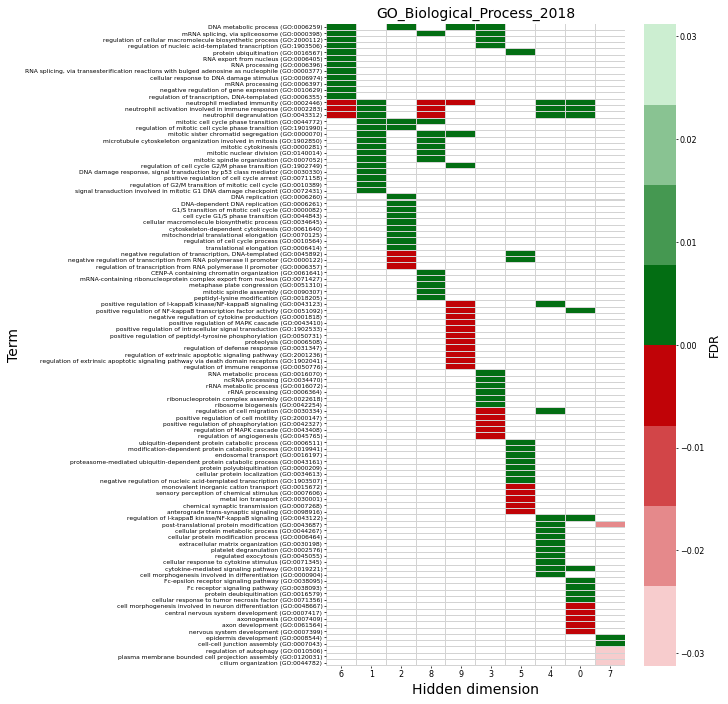

In [207]:
# Overwrite some plotting params
width = 170 / mm_per_inch
height = 300 / mm_per_inch
ytick_font_size = 6
title_font_size = 14
ylabel_size = 6
xlabel_size = 12

# Establish params for visualization
gene_set = "GO_Biological_Process_2018"
sign_threshold = 0.05
value = "fdr"
top_k_terms = 15

# Preprocess and the enrichments
enrich_df_combined = results_dict[gene_set][0]
enrich_df_combined["signed " + value] = enrich_df_combined.apply(signed_fdr_maker, axis=1)
enrich_df_filtered = enrich_df_combined[enrich_df_combined[value] < sign_threshold] 
if top_k_terms:
    enrich_df_topk_combined = enrich_df_filtered.iloc[:0]
    for dim in range(10):
        df = enrich_df_filtered[enrich_df_filtered["Dim"] == dim]
        df_top = df.sort_values(value).iloc[:top_k_terms]
        enrich_df_topk_combined = pd.concat((enrich_df_topk_combined, df_top))
if top_k_terms:
    enrich_df_pivoted = enrich_df_topk_combined.reset_index().pivot_table(values="signed " + value, index="Dim", columns="Term")
else:
    enrich_df_pivoted = enrich_df_filtered.reset_index().pivot_table(values="signed " + value, index="Dim", columns="Term")
print(enrich_df_topk_combined.shape, enrich_df_topk_combined.index.to_series().nunique(), enrich_df_pivoted.shape)
print()
plt.figure(figsize=(width, height))
plt.yticks(fontsize=ytick_font_size)
plt.title(gene_set, fontsize=title_font_size)
cmap = sns.diverging_palette(h_neg=12, h_pos=129, s=99, l=40, sep=7, n=8, center="light", as_cmap=False)
cmap = cmap[:len(cmap) // 2][::-1] + cmap[len(cmap) // 2:][::-1]
# Establish max absolute value for color mapping
if enrich_df_pivoted.max().max() > np.abs(enrich_df_pivoted.min().min()):
    vmax = enrich_df_pivoted.max().max()
else:
    vmax = np.abs(enrich_df_pivoted.min().min()) 
df = sort_pivoted_dataframe(enrich_df_pivoted.transpose())
ax = sns.heatmap(df, yticklabels=True, cmap=cmap, linewidths=0.01, linecolor="lightgray",
                cbar_kws={"label": "FDR"}, center=0.0, vmax=vmax, vmin=-vmax)
ax.figure.axes[-1].yaxis.label.set_size(12)
plt.ylabel("Term", fontsize=14)
plt.xlabel("Hidden dimension", fontsize=14)
# ax.get_figure().savefig(
#     os.path.join(
#     filepath, "{} enrichment heatmap, {} terms from every dimension, {} {} threshold.pdf".format(gene_set, top_k_terms, sign_threshold, value)), bbox_inches='tight')
plt.show()

#### Get lists of terms in every dimension to put it in Revigo

In [146]:
print(df.shape)
df.head(2)

(102, 10)


Dim,6,1,2,8,9,3,5,4,0,7
Term,,,,,,,,,,
DNA metabolic process (GO:0006259),1.000000e-08,NaN,1.000000e-08,NaN,1.000000e-08,1.000000e-08,NaN,NaN,NaN,NaN
"mRNA splicing, via spliceosome (GO:0000398)",1.000000e-08,NaN,NaN,1.000000e-08,NaN,1.000000e-08,NaN,NaN,NaN,NaN


In [153]:
get_go_id = lambda t: t.split("(")[1][:-1]

In [162]:
get_go_id = lambda t: t.split("(")[1][:-1]
for dim in df.columns:
    terms = df[dim][~df[dim].isnull()].index
    terms = list(terms.map(get_go_id))
    print(len(terms))
    # Write into a file
    with open(os.path.join(panels_filepath, "Fig3 GO terms lists", "enriched_terms_{}_dim.txt".format(dim)), 'w') as f:
        for item in terms:
            f.write("%s\n" % item)

15
15
15
15
15
15
15
15
15
6


In [37]:
df.head(2)

Dim,6,1,2,8,9,3,5,4,0,7
Term,,,,,,,,,,
DNA metabolic process (GO:0006259),1.000000e-08,NaN,1.000000e-08,NaN,1.000000e-08,1.000000e-08,NaN,NaN,NaN,NaN
"mRNA splicing, via spliceosome (GO:0000398)",1.000000e-08,NaN,NaN,1.000000e-08,NaN,1.000000e-08,NaN,NaN,NaN,NaN


In [54]:
# Compute terms along with FDR
get_go_id = lambda t: t.split("(")[1][:-1]
for dim in df.columns:
    terms = df[dim][~df[dim].isnull()]
    terms.index = terms.index.map(get_go_id)
    terms.to_csv(
        os.path.join(panels_filepath, "Fig3 GO terms lists", "enriched_terms_with_FDR_{}_dim.txt".format(dim)),
        sep=" ")

/home/krzysztof/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  


#### Update terms with Revigo

In [208]:
# Create a mapper from GO name to GO ID and vice versa
go_term_to_go_id = {}
go_name_to_go_id = {}
go_id_to_go_name = {}
for term in df.index:
    name = term.split(" (")[0]
    ide = term.split(" (")[1][:-1]
    go_term_to_go_id[term] = ide
    go_name_to_go_id[name] = ide
    go_id_to_go_name[ide] = name
print(len(go_term_to_go_id), len(go_name_to_go_id), len(go_id_to_go_name))

102 102 102


In [209]:
# Create a list of redundant go terms
terms_to_eliminate = []
for dim in range(10):
    filepath = os.path.join(panels_filepath, "Fig3 GO terms lists", "REVIGO({}).csv".format(dim))
    revigo_df = pd.read_csv(filepath)
    terms_to_eliminate = terms_to_eliminate + list(revigo_df[revigo_df.eliminated == 1]["term_ID"])
print(len(terms_to_eliminate))
terms_to_eliminate = list(set(terms_to_eliminate))
print(len(terms_to_eliminate))

45
35


In [210]:
print(df.shape)
df.index = df.index.map(go_term_to_go_id)
df.head(2)

(102, 10)


Dim,6,1,2,8,9,3,5,4,0,7
Term,,,,,,,,,,
GO:0006259,1.000000e-08,NaN,1.000000e-08,NaN,1.000000e-08,1.000000e-08,NaN,NaN,NaN,NaN
GO:0000398,1.000000e-08,NaN,NaN,1.000000e-08,NaN,1.000000e-08,NaN,NaN,NaN,NaN


In [211]:
# Eliminate the terms
print(df.shape)
df = df[~df.index.isin(terms_to_eliminate)]
print(df.shape)

(102, 10)
(67, 10)


#### Create term name abbrevations

In [213]:
# Map GO IDs back to term names
df.index = df.index.map(go_id_to_go_name)
print(df.shape)
df.head(2)

(67, 10)


Dim,6,1,2,8,9,3,5,4,0,7
Term,,,,,,,,,,
DNA metabolic process,1.000000e-08,NaN,1.000000e-08,NaN,1.000000e-08,1.000000e-08,NaN,NaN,NaN,NaN
regulation of cellular macromolecule biosynthetic process,1.000000e-08,NaN,NaN,NaN,NaN,1.000000e-08,NaN,NaN,NaN,NaN


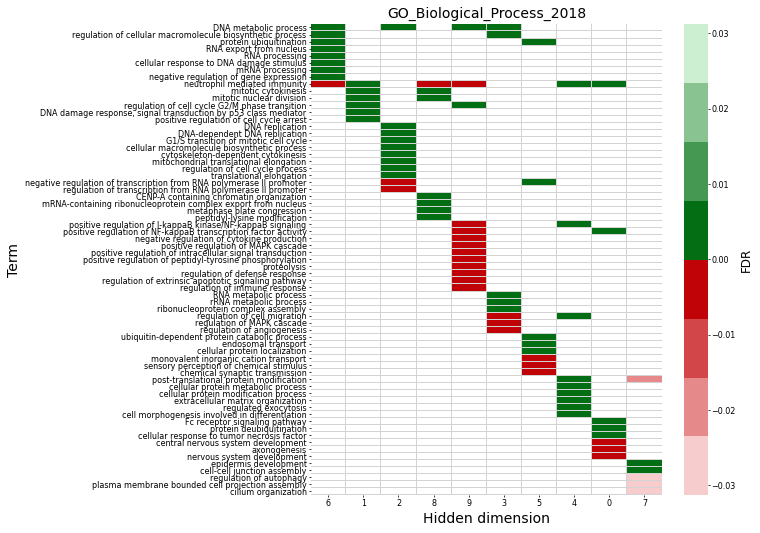

In [160]:
# Test plot the clustermap with original names
width = 200 / mm_per_inch
height = 220 / mm_per_inch
ytick_font_size = 8
title_font_size = 14
ylabel_size = 12
xlabel_size = 12

plt.figure(figsize=(width, height))
plt.yticks(fontsize=ytick_font_size)
plt.title(gene_set, fontsize=title_font_size)
cmap = sns.diverging_palette(h_neg=12, h_pos=129, s=99, l=40, sep=7, n=8, center="light", as_cmap=False)
cmap = cmap[:len(cmap) // 2][::-1] + cmap[len(cmap) // 2:][::-1]
# Establish max absolute value for color mapping
if enrich_df_pivoted.max().max() > np.abs(enrich_df_pivoted.min().min()):
    vmax = enrich_df_pivoted.max().max()
else:
    vmax = np.abs(enrich_df_pivoted.min().min()) 
#df = sort_pivoted_dataframe(enrich_df_pivoted.transpose())
ax = sns.heatmap(df, yticklabels=True, cmap=cmap, linewidths=0.01, linecolor="lightgray",
                cbar_kws={"label": "FDR"}, center=0.0, vmax=vmax, vmin=-vmax)
ax.figure.axes[-1].yaxis.label.set_size(12)
plt.ylabel("Term", fontsize=14)
plt.xlabel("Hidden dimension", fontsize=14)
plt.show()

In [163]:
# Create a list with all words in term names
all_words = []
for t in df.index:
    all_words = all_words + t.split(" ")
print(len(all_words))

266


In [177]:
all_words.count("signaling")

3

In [196]:
# Create a dictionary with word abbreviations
word_abbreviations = {"process": "proc.",
                      "regulation": "reg.",
                      "response": "resp.",
                      "response,": "resp.,",
                      "negative": "neg.",
                      "positive": "pos.",
                      "transcription": "transcr.",
                      "transduction": "transd.",
                      "mRNA-containing": "mRNA-cont.",
                      "damage": "dam.",
                      "nucleus": "nucl."}

In [197]:
def abbreviate_term(t):
    words = t.split(" ")
    abbr_words = [word_abbreviations[w] if w in word_abbreviations else w for w in words]
    return " ".join(abbr_words)

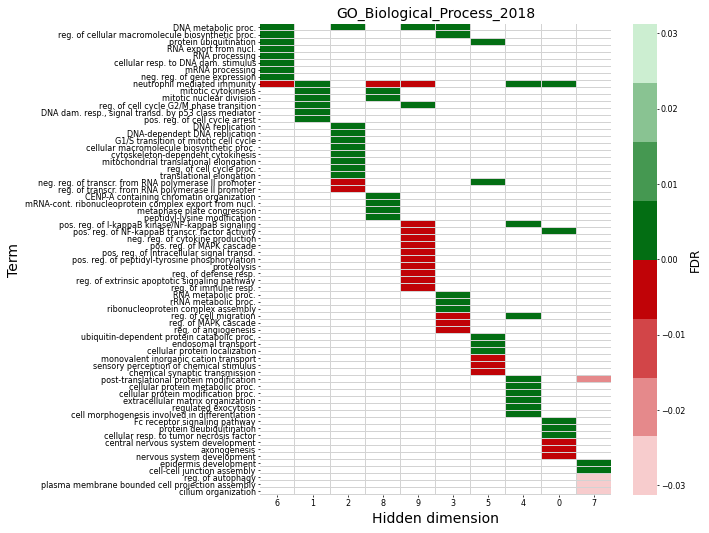

In [198]:
# Plot with abbreviations
# Test plot the clustermap with original names
width = 200 / mm_per_inch
height = 220 / mm_per_inch
ytick_font_size = 8
title_font_size = 14
ylabel_size = 12
xlabel_size = 12

plt.figure(figsize=(width, height))
plt.yticks(fontsize=ytick_font_size)
plt.title(gene_set, fontsize=title_font_size)
cmap = sns.diverging_palette(h_neg=12, h_pos=129, s=99, l=40, sep=7, n=8, center="light", as_cmap=False)
cmap = cmap[:len(cmap) // 2][::-1] + cmap[len(cmap) // 2:][::-1]
# Establish max absolute value for color mapping
if enrich_df_pivoted.max().max() > np.abs(enrich_df_pivoted.min().min()):
    vmax = enrich_df_pivoted.max().max()
else:
    vmax = np.abs(enrich_df_pivoted.min().min()) 
#df = sort_pivoted_dataframe(enrich_df_pivoted.transpose())
df.index = df.index.map(abbreviate_term)
ax = sns.heatmap(df, yticklabels=True, cmap=cmap, linewidths=0.01, linecolor="lightgray",
                cbar_kws={"label": "FDR"}, center=0.0, vmax=vmax, vmin=-vmax)
ax.figure.axes[-1].yaxis.label.set_size(12)
plt.ylabel("Term", fontsize=14)
plt.xlabel("Hidden dimension", fontsize=14)
plt.show()

In [216]:
# Save heatmap after revigo and abbreviations dict
df.to_csv(os.path.join(panels_filepath, "Fig3 GO terms lists", "gsea_heatmap_biol_proc_after_revigo.csv"),
         index=True)

In [ ]:
with open(os.path.join(panels_filepath, "Fig3 GO terms lists", "word_abbr_dict.pkl"), "wb") as f:
    dill.dump(word_abbreviations, f)

In [ ]:
word_abbreviations = {"process": "proc.",
                      "regulation": "reg.",
                      "response": "resp.",
                      "response,": "resp.,",
                      "negative": "neg.",
                      "positive": "pos.",
                      "transcription": "transcr.",
                      "transduction": "transd.",
                      "mRNA-containing": "mRNA-cont.",
                      "damage": "dam.",
                      "nucleus": "nucl."}

#### Load the updated heatmap and abbreviations dict

In [7]:
def abbreviate_term(t):
    words = t.split(" ")
    abbr_words = [word_abbreviations[w] if w in word_abbreviations else w for w in words]
    return " ".join(abbr_words)

enrich_df = pd.read_csv(os.path.join(panels_filepath, "Fig3 GO terms lists", "gsea_heatmap_biol_proc_after_revigo_sorted.csv"),
                index_col=0)
with open(os.path.join(panels_filepath, "Fig3 GO terms lists", "word_abbr_dict.pkl"), "rb") as f:
    word_abbreviations = dill.load(f)
print(enrich_df.shape, len(word_abbreviations))
enrich_df.head(2)

(67, 10) 17


,9,2,6,4,3,5,0,8,1,7
Term,,,,,,,,,,
DNA metabolic proc.,1.000000e-08,1.000000e-08,1.000000e-08,NaN,1.000000e-08,NaN,NaN,NaN,NaN,NaN
reg. of cell cycle G2/M phase transition,1.000000e-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000e-08,NaN


In [8]:
for t in enrich_df.index:
    print(t)

DNA metabolic proc.
reg. of cell cycle G2/M phase transition
neutrophil mediated immunity
pos. reg. of I-kappaB kinase/NF-kappaB signaling
pos. reg. of NF-kappaB transcr. factor activity
neg. reg. of cytokine production
pos. reg. of MAPK cascade
pos. reg. of intracellular signal transd.
pos. reg. of peptidyl-tyrosine phosphorylation
proteolysis
reg. of defense resp.
reg. of extrinsic apoptotic signaling pathway
reg. of immune resp.
DNA replication
DNA-dependent DNA replication
G1/S transition of mitotic cell cycle
cellul. macromol. biosyn. proc.
cytoskeleton-dependent cytokinesis
mitochondrial translational elongation
reg. of cell cycle proc.
translational elongation
neg. reg. of transcr. from RNA polymerase II promoter
reg. of transcr. from RNA polymerase II promoter
reg. of cellul. macromol. biosyn. proc.
protein ubiquitination
RNA export from nucl.
RNA processing
cellul. resp. to DNA dam. stimulus
mRNA processing
neg. reg. of gene expression
post-translational protein modification
c

In [75]:
d = {"signaling": "signal.",
    "activity": "act.",
    "transition": "trans."}

word_abbreviations.update(d)

In [76]:
print(len(word_abbreviations))
word_abbreviations

17


{'process': 'proc.',
 'regulation': 'reg.',
 'response': 'resp.',
 'response,': 'resp.,',
 'negative': 'neg.',
 'positive': 'pos.',
 'transcription': 'transcr.',
 'transduction': 'transd.',
 'mRNA-containing': 'mRNA-cont.',
 'damage': 'dam.',
 'nucleus': 'nucl.',
 'macromolecule': 'macromol.',
 'biosynthetic': 'biosyn.',
 'cellular': 'cellul.',
 'signaling': 'signal.',
 'activity': 'act.',
 'transition': 'trans.'}

In [77]:
with open(os.path.join(panels_filepath, "Fig3 GO terms lists", "word_abbr_dict.pkl"), "wb") as f:
    dill.dump(word_abbreviations, f)

#### Plot the updated clustermap

In [ ]:
# Helper functions
def signed_fdr_maker(row, value="fdr"):
    if row[value] == 0:
        if row["es"] > 0:
            return 0.00000001
        elif row["es"] < 0:
            return -0.00000001
        else:
            return 0
    else:
        if row["es"] != 0:
            return np.sign(row["es"]) * row[value]
        else:
            return row[value]
        
def sort_pivoted_dataframe(df):
    """Organize the enrichments in a pivoted DataFrame considering the importance of the dimensions"""
    # Get the order of the columns
    dim_counts_mat = np.zeros((df.shape[1], 2))
    for dim in list(df):
        # Calculate how many enriched columns are there
        dim_counts_mat[int(dim), 0] = df[dim].notnull().sum()
        # Calculate the sum of absolute fdr values
        dim_counts_mat[int(dim), 1] = np.abs(df[dim]).sum()
    dim_counts_df = pd.DataFrame(dim_counts_mat, columns=["Count", "FDR sum"])
    # Sort first by count of significant term, then by sum of fdr
    dim_order = list(dim_counts_df.sort_values(["Count", "FDR sum"], ascending=[False, True]).index)
    dim_order = [str(x) for x in dim_order]
    # Reorganize the columns of a DataFrame
    df = df[dim_order]
    # Iterate over dimensions and sort values w.r.t every dimension
    for dim in dim_order[::-1]:
        df["Inversed value"] = 1. / df[dim]
        df = df.sort_values("Inversed value", ascending=False)
    return df[dim_order]

strip_go_id = lambda x: x.split(" (")[0]

In [48]:
# Set up plotting params
# Size in milimeters
panel_width_mm = full_page_figure_width_mm / 2
panel_height_mm = 80

# Size in inches
panel_width_inch = panel_width_mm / mm_per_inch
panel_height_inch = panel_height_mm / mm_per_inch

print("Width:", panel_width_mm, panel_width_inch)
print("Height:", panel_height_mm, panel_height_inch)

# Update rcParams
params = {
        'figure.figsize'      : [panel_width_inch, panel_height_inch] ,
        'font.size'           : 10      ,
        #'font.sans-serif'     : 'Arial'    ,
        'axes.titlesize'      : 12.       ,
        'axes.labelsize'      : 9.       ,
        'xtick.major.size'    : 2        ,
        'xtick.major.width'   : 0.75     ,
        'xtick.labelsize'     : 8.0      ,
        'xtick.direction'     : 'out'      ,
        'ytick.major.size'    : 2        ,
        'ytick.major.width'   : 0.75     ,
        'ytick.labelsize'     : 8.0      ,
        'ytick.direction'     : 'out'      ,
        'xtick.major.pad'     : 2        ,
        'xtick.minor.pad'     : 2        ,
        'ytick.major.pad'     : 2        ,
        'ytick.minor.pad'     : 2        ,
        'savefig.dpi'         : global_dpi      ,
        'axes.linewidth'      : 0.75     ,
        'text.usetex'         : False     ,
        'text.latex.unicode'  : False     }
plt.rcParams.update(params)
print(plt.rcParams.get('figure.figsize'))
print(plt.rcParams.get('font.size'))

Width: 85.0 3.346456692913386
Height: 80 3.1496062992125986


/home/krzysztof/anaconda3/envs/modeling_drug_efficacy/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]


[3.346456692913386, 3.1496062992125986]
10.0


In [49]:
# Establish colormap
#sns.choose_diverging_palette()

In [50]:
cmap = sns.diverging_palette(h_neg=28, h_pos=256, s=99, l=55, sep=7, n=8, center="light", as_cmap=False)
cmap

[(0.8272622303696421, 0.3913512532394865, 0.025691999629397888),
 (0.8767038799985519, 0.5528878733955431, 0.2812582850309868),
 (0.9274819315179695, 0.7187908091212283, 0.5437324966349628),
 (0.977589171932191, 0.8825020591020022, 0.8027392530943811),
 (0.8130775508356495, 0.8924106905426169, 0.9988976877175952),
 (0.5870408618375129, 0.7623079051893165, 0.9975647123597897),
 (0.35797810475204406, 0.6304633676957961, 0.9962138917830983),
 (0.13494393467324511, 0.5020887799913518, 0.9948986227708801)]

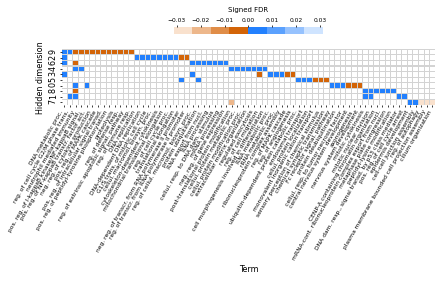

In [68]:
# Visualize enrichments within single gene library
# Overwrite some plotting params
width = 170 / mm_per_inch
height = 140 / mm_per_inch
ytick_font_size = 8
xtick_font_size = 6
title_font_size = 14
ylabel_size = 8
xlabel_size = 8

plt.figure(figsize=(width, height))
#plt.title(gene_set, fontsize=title_font_size)
#cmap = sns.diverging_palette(h_neg=12, h_pos=129, s=99, l=40, sep=7, n=8, center="light", as_cmap=False)
cmap = sns.diverging_palette(h_neg=28, h_pos=256, s=99, l=55, sep=7, n=8, center="light", as_cmap=False)
cmap = cmap[:len(cmap) // 2][::-1] + cmap[len(cmap) // 2:][::-1]
# Establish max absolute value for color mapping
if enrich_df.max().max() > np.abs(enrich_df.min().min()):
    vmax = enrich_df.max().max()
else:
    vmax = np.abs(enrich_df.min().min()) 
enrich_df.index = enrich_df.index.map(abbreviate_term)
ax = sns.heatmap(enrich_df.transpose(), yticklabels=True, xticklabels=True, cmap=cmap, linewidths=0.01, linecolor="lightgray",
                cbar_kws={"shrink": 0.4, "use_gridspec": False, "location": "top"}, 
                 center=0.0, vmax=vmax, vmin=-vmax, square=True, cbar=True)

ax.figure.axes[-1].yaxis.label.set_size(2)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=6)
cbar.ax.set_title("Signed FDR", fontsize=7)
plt.yticks(fontsize=ytick_font_size, rotation=90)
plt.xticks(fontsize=xtick_font_size, rotation=60, ha="right")
plt.ylabel("Hidden dimension", fontsize=ylabel_size)
plt.xlabel("Term", fontsize=xlabel_size)
#plt.tight_layout()
ax.get_figure().savefig(
    os.path.join(panels_filepath, "Fig3_GO_Biological_Process_2018_enrich_heatmap_after_revigo_sorted.pdf"),
            bbox_inches="tight")

# plt.savefig(os.path.join(panels_filepath, "Fig3_GO_Biological_Process_2018_enrich_heatmap_after_revigo.pdf"),
#                  bbox_inches="tight")
plt.show()

In [58]:
cbar = ax.collections[0].colorbar

In [270]:
dict(use_gridspec=False,location="top")

{'use_gridspec': False, 'location': 'top'}

### Combine terms from multiple gene libraries

#### Compute grand enrichment DataFrame

In [102]:
with open(os.path.join(model_dir, "Gene set enrichment analysis/Cell lines/Correlations with features outside input data/",
                       "GSEA Preranked Top 1000 genes", 
                       "gsea_preranked_enrichment_results_in_different_gene_sets_top_1000_genes_results_dict.pkl"), "rb") as f:
    results_dict = dill.load(f)
print(len(results_dict))
print(results_dict.keys())

3
dict_keys(['GO_Biological_Process_2018', 'GO_Molecular_Function_2018', 'KEGG_2019_Human'])


In [103]:
df = results_dict["GO_Biological_Process_2018"][0]
df.head(2)

,es,nes,pval,fdr,geneset_size,matched_size,genes,ledge_genes,Dim
Term,,,,,,,,,
cytokine-mediated signaling pathway (GO:0019221),0.338071,3.041110,0.0,0.0,634,80,PTPN6;PTAFR;TNFRSF10A;NFKB1;MYD88;MAP3K8;PTK2B...,PTPN6;PTAFR;TNFRSF10A;NFKB1;MYD88;MAP3K8;PTK2B...,0
nervous system development (GO:0007399),-0.352511,-3.185949,0.0,0.0,456,93,MBNL1;TAOK3;LYN;GRHL2;BPNT1;CDH1;TRAK1;ALDH5A1...,ST8SIA2;SCN8A;ZNF358;FGF2;PCDHB14;NRCAM;PCDHB1...,0


In [86]:
for gene_set in results_dict:
    df = results_dict[gene_set][0]
    print(df.shape)

(2834, 9)
(716, 9)
(823, 9)


In [89]:
# Create one big enrichments DataFrame
grand_enrich_df = pd.DataFrame(columns=list(df) + ["Library"])
for gene_set in results_dict:
    df = results_dict[gene_set][0]
    df["Library"] = df.shape[0] * [gene_set]
    grand_enrich_df = pd.concat((grand_enrich_df, df), axis=0)
print(grand_enrich_df.shape)
grand_enrich_df.head(2)

(4373, 10)


,es,nes,pval,fdr,geneset_size,matched_size,genes,ledge_genes,Dim,Library
cytokine-mediated signaling pathway (GO:0019221),0.338071,3.041110,0.0,0.0,634,80,PTPN6;PTAFR;TNFRSF10A;NFKB1;MYD88;MAP3K8;PTK2B...,PTPN6;PTAFR;TNFRSF10A;NFKB1;MYD88;MAP3K8;PTK2B...,0,GO_Biological_Process_2018
nervous system development (GO:0007399),-0.352511,-3.185949,0.0,0.0,456,93,MBNL1;TAOK3;LYN;GRHL2;BPNT1;CDH1;TRAK1;ALDH5A1...,ST8SIA2;SCN8A;ZNF358;FGF2;PCDHB14;NRCAM;PCDHB1...,0,GO_Biological_Process_2018


In [98]:
# Save the grand enrichment DataFrame
grand_enrich_df.to_csv(os.path.join(model_dir, 
    "Gene set enrichment analysis/Cell lines/Correlations with features outside input data/GSEA Preranked Top 1000 genes/",
    "gsea_preranked_enrichment_results_in_different_gene_sets_top_1000_genes_table.csv"), index=True)

#### Load grand enrichment DataFrame

In [105]:
# Load the grand enrichment DataFrame
grand_enrich_df = pd.read_csv(os.path.join(model_dir, 
    "Gene set enrichment analysis/Cell lines/Correlations with features outside input data/GSEA Preranked Top 1000 genes/",
    "gsea_preranked_enrichment_results_in_different_gene_sets_top_1000_genes_table.csv"), index_col=0)
grand_enrich_df.index.name = "Term"
print(grand_enrich_df.shape)
grand_enrich_df.head(2)

(4373, 10)


,es,nes,pval,fdr,geneset_size,matched_size,genes,ledge_genes,Dim,Library
Term,,,,,,,,,,
cytokine-mediated signaling pathway (GO:0019221),0.338071,3.041110,0.0,0.0,634,80,PTPN6;PTAFR;TNFRSF10A;NFKB1;MYD88;MAP3K8;PTK2B...,PTPN6;PTAFR;TNFRSF10A;NFKB1;MYD88;MAP3K8;PTK2B...,0,GO_Biological_Process_2018
nervous system development (GO:0007399),-0.352511,-3.185949,0.0,0.0,456,93,MBNL1;TAOK3;LYN;GRHL2;BPNT1;CDH1;TRAK1;ALDH5A1...,ST8SIA2;SCN8A;ZNF358;FGF2;PCDHB14;NRCAM;PCDHB1...,0,GO_Biological_Process_2018


## Figure 4: Drug cases

### Load model retrained on whole data

In [7]:
! ls "../Final results/Models retrained on the whole data/One-layer autoencoders, two-layer code forwarding, with data augmentation, MinMaxScaled IC50 - params from experiment 4 - replay/" | grep .pkl

retrained_model_all_cl_feats_scaled.pkl
retrained_model.pkl
retrained_without_augmentation.pkl
retrained_without_independence_loss.pkl


In [8]:
# Establish filepath to the experiment
model_dir = "../Final results/Models retrained on the whole data/One-layer autoencoders, two-layer code forwarding, with data augmentation, MinMaxScaled IC50 - params from experiment 4 - replay/"

In [9]:
# Load model trained with independence loss
with open(os.path.join(model_dir, "retrained_model.pkl"), "rb") as f:
    retrained_model = dill.load(f)
retrained_network = retrained_model.network
print(type(retrained_model), type(retrained_network))
retrained_network.eval()

<class 'modeling.ModelWithAutoencoders'> <class 'architectures.RecSystemCodeConcatenation'>


RecSystemCodeConcatenation(
  (drug_autoencoder): DeepAutoencoderOneHiddenLayer(
    (encoder): Sequential(
      (0): Linear(in_features=294, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=10, bias=True)
    )
    (decoder): Sequential(
      (0): Linear(in_features=10, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=294, bias=True)
    )
  )
  (cell_line_autoencoder): DeepAutoencoderOneHiddenLayer(
    (encoder): Sequential(
      (0): Linear(in_features=241, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=10, bias=True)
    )
    (decoder): Sequential(
      (0): Linear(in_features=10, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=241, bias=True)
    )
  )
  (forward_network): ForwardNetworkTwoHiddenLayers(
    (layers): Sequential(
      (0): Linear(in_features=20, out_features=512, bias=True)


### Model visualization widget for testing

In [33]:
def two_d_plot_widget(drug_name, display_drug_meta, cl_axis1, cl_axis2, display_feature_importances, 
                      normalize_feat_imp, k_important_feats, feature_type, display_response_vs_feat):
    # Get drug GDSC ID
    drug_id = full_dataset.gdsc_name_to_gdsc_id_mapper[drug_name]
    print(drug_id)
    # Display drug meta if specified
    if display_drug_meta:
        display(full_dataset.drug_metadata[full_dataset.drug_metadata["Drug ID"] == drug_id][
            ["Drug ID", "Name", "Targets", "Target pathway", "PubCHEM"]].style.set_caption("Drug metadata"))
    # Compute codes and reconstructions for drug an cell lines
    # Compute reconstructions for drugs
    drug_codes, drug_recs = retrained_network.drug_autoencoder(torch.from_numpy(drug_data_df.values).float())
    # Create a DataFrame with drugs and their code embeddings
    drug_codes_df = pd.DataFrame(drug_codes.detach().numpy(), index=drug_data_df.index)
    # Compute reconstructions for all cell lines
    cl_codes, cl_recs = retrained_network.cell_line_autoencoder(torch.from_numpy(
        cell_line_data_df.values).float())
    # Create a DataFrame with cell lines and their code embeddings
    cl_codes_df = pd.DataFrame(cl_codes.detach().numpy(), index=cell_line_data_df.index)
    
    # Code visualizations for a given drug
    samples = samples_all[samples_all["DRUG_ID"] == drug_id]
    sampled_cell_lines_codes = cl_codes_df.loc[samples["COSMIC_ID"].values]
    sampled_cell_lines_codes["True " + str(global_response_metric)] = samples[global_response_metric].values
    
    # Visualize by two most variant code dimensions
    # Visualize in 2D
    if not (cl_axis1 is None and cl_axis2 is None):
        # Extract top 2 diagonal indexes
        cl_codes_cov = np.cov(cl_codes.detach().numpy(), rowvar=False)
        top_2 = cl_codes_cov.diagonal().argsort()[-2:][::-1]
        if (cl_axis1 == "max") or (cl_axis2 == "max"):
            cl_axis1, cl_axis2 = top_2[0], top_2[1]
        if cl_axis1 is not None: 
            sns.set_style("dark")
            plt.figure(figsize=(5, 4))
            cmap = matplotlib.colors.ListedColormap(sns.color_palette("YlOrRd"))
            plt.title("Cell lines in code space: " + drug_name)
            plt.scatter(sampled_cell_lines_codes[cl_axis1], sampled_cell_lines_codes[cl_axis2], 
                        c=sampled_cell_lines_codes["True " + str(global_response_metric)].values, s=20., 
                        cmap=cmap)
            plt.xlabel("Axis {}".format(cl_axis1))
            plt.ylabel("Axis {}".format(cl_axis2))
            #plt.legend()
            plt.grid(False)
            plt.colorbar()
        if cl_axis1 is None:
            plt.figure(figsize=(5, 4))
            plt.title("True response vs. latent dimension: " + drug_name)
            sns.regplot(sampled_cell_lines_codes[cl_axis2], 
                        sampled_cell_lines_codes["True " + str(global_response_metric)].values,
                        scatter_kws={"s":20})
    # Display feature sensitivities if specified
    if display_feature_importances:
        # Analyze whole rec system
        def net(drug_input, cl_input):
            return retrained_network(drug_input, cl_input)[0]
        
        ig = IntegratedGradients(net)
        # Establish samples on which to compute importances
        samples  = samples_all[samples_all["DRUG_ID"] == drug_id]
        cl_input = torch.from_numpy(cell_line_data_df.loc[samples["COSMIC_ID"].values].values).float()
        drug_input = torch.from_numpy(drug_data_df.loc[samples["DRUG_ID"].values].values).float()
        cl_input.requires_grad_()
        drug_input.requires_grad_()
        attributions, delta = ig.attribute((drug_input, cl_input), return_convergence_delta=True)
        drug_attributions, cl_attributions = attributions
        drug_attributions = drug_attributions.detach().numpy()
        cl_attributions = cl_attributions.detach().numpy()
        drug_attributions = np.mean(drug_attributions, axis=0)
        cl_attributions = np.mean(cl_attributions, axis=0)
        if normalize_feat_imp:
            drug_attributions = drug_attributions / np.abs(drug_attributions).sum()
            cl_attributions = cl_attributions / np.abs(cl_attributions).sum()
        drug_attributions = [x for x in zip(list(drug_data_df.columns), drug_attributions)]
        cl_attributions = [x for x in zip(list(cell_line_data_df.columns), cl_attributions)]

        all_features_attributions = drug_attributions + cl_attributions
        # Sort by importance
        drug_attributions = sorted(drug_attributions, key=lambda x: abs(x[1]), reverse=True)
        cl_attributions = sorted(cl_attributions, key=lambda x: abs(x[1]), reverse=True)

        # Plot k most important drug or cell line features
        if feature_type == "cell line":
            plt.figure()
            sns.barplot(x=[x[0] for x in cl_attributions[:k_important_feats]], y=[x[1] for x in cl_attributions[:k_important_feats]])
            plt.title("{} feature importances: {}".format("Cell line", drug_name))
            plt.xticks(rotation=90, fontsize=8)
        elif feature_type == "both":
            plt.figure()
            plt.title("{} feature importances: {}".format("Cell line", drug_name))
            sns.barplot(x=[x[0] for x in cl_attributions[:k_important_feats]], y=[x[1] for x in cl_attributions[:k_important_feats]])
            plt.xticks(rotation=90, fontsize=8)
            
            plt.figure()
            plt.title("{} feature importances: {}".format("Drug", drug_name))
            sns.barplot(x=[x[0] for x in drug_attributions[:k_important_feats]], y=[x[1] for x in drug_attributions[:k_important_feats]])
            plt.xticks(rotation=90, fontsize=8)
        else:
            plt.figure()
            sns.barplot(x=[x[0] for x in drug_attributions[:k_important_feats]], y=[x[1] for x in drug_attributions[:k_important_feats]])
            plt.title("{} feature importances: {}".format("Drug", drug_name))
            plt.xticks(rotation=90, fontsize=8)
            
        if display_response_vs_feat:
            response_predictions = net(drug_input, cl_input)
            true_response = samples[global_response_metric]
            def plot_response_vs_feat(feature, response):
                x = cell_line_data_original_df.loc[samples["COSMIC_ID"].values][feature]
                if response == "predicted":
                    y = response_predictions.detach().numpy().reshape(-1)
                else:
                    y = true_vals
                plt.figure()
                sns.regplot(x, y)
                plt.title("Response vs {}".format(feature))
                plt.xlabel(feature)
                plt.ylabel(global_response_metric)
            interact(plot_response_vs_feat,
            feature=[x[0] for x in cl_attributions[:k_important_feats]],
            response=["predicted", "true"])
        plt.show()
    


two_d_plot_widget_result = interactive(two_d_plot_widget,
            drug_name=[x for x in full_dataset.gdsc_name_to_gdsc_id_mapper.keys()],
            display_drug_meta=[False, True],
            cl_axis1=[None] + ["max"] + [x for x in range(10)],
            cl_axis2=[None] + ["max"] + [x for x in range(10)],
            display_feature_importances=[False, True],
            normalize_feat_imp=[False, True],
            k_important_feats=widgets.IntSlider(value=10, min=1, max=30,step=1),
            feature_type=["cell line", "drug", "both"],
            display_response_vs_feat=[False, True])

display(two_d_plot_widget_result)

interactive(children=(Dropdown(description='drug_name', options=('(5Z)-7-Oxozeaenol', 'A-443654', 'A-770041', …

In [239]:
name = "MEK"
for g in (drug_data_df):
    if g.startswith(name):
        print(g)

In [230]:
def abbreviate_term(t):
    words = t.split(" ")
    abbr_words = [word_abbreviations[w] if w in word_abbreviations else w for w in words]
    return " ".join(abbr_words)

# Load the enrichment heatmap and investigate
enrich_heatmap_df = pd.read_csv(os.path.join(panels_filepath, "Fig3 GO terms lists", "gsea_heatmap_biol_proc_after_revigo.csv"),
                index_col=0)
enrich_heatmap_df.index = enrich_heatmap_df.index.map(abbreviate_term)

with open(os.path.join(panels_filepath, "Fig3 GO terms lists", "word_abbr_dict.pkl"), "rb") as f:
    word_abbreviations = dill.load(f)
print(enrich_heatmap_df.shape, len(word_abbreviations))
enrich_heatmap_df.head(2)

(67, 10) 11


,6,1,2,8,9,3,5,4,0,7
Term,,,,,,,,,,
DNA metabolic proc.,1.000000e-08,NaN,1.000000e-08,NaN,1.000000e-08,1.000000e-08,NaN,NaN,NaN,NaN
reg. of cellular macromolecule biosynthetic proc.,1.000000e-08,NaN,NaN,NaN,NaN,1.000000e-08,NaN,NaN,NaN,NaN


In [231]:
for dim in list(enrich_heatmap_df):
    print(dim)
    print(enrich_heatmap_df[enrich_heatmap_df[dim].notnull()].index)
    print()

6
Index(['DNA metabolic proc.',
       'reg. of cellular macromolecule biosynthetic proc.',
       'protein ubiquitination', 'RNA export from nucl.', 'RNA processing',
       'cellular resp. to DNA dam. stimulus', 'mRNA processing',
       'neg. reg. of gene expression', 'neutrophil mediated immunity'],
      dtype='object', name='Term')

1
Index(['neutrophil mediated immunity', 'mitotic cytokinesis',
       'mitotic nuclear division', 'reg. of cell cycle G2/M phase transition',
       'DNA dam. resp., signal transd. by p53 class mediator',
       'pos. reg. of cell cycle arrest'],
      dtype='object', name='Term')

2
Index(['DNA metabolic proc.', 'DNA replication',
       'DNA-dependent DNA replication',
       'G1/S transition of mitotic cell cycle',
       'cellular macromolecule biosynthetic proc.',
       'cytoskeleton-dependent cytokinesis',
       'mitochondrial translational elongation', 'reg. of cell cycle proc.',
       'translational elongation',
       'neg. reg. of transc

In [65]:
"PHA-793887" 3  ?(3, 0)
"XMD14-99": 3, 5?   (3, 4)
"Dabrafenib": 3,4   ?2, 3, 4, 6 (4, 8)?  (3, 4)

In [172]:
per_drug_performance_df["Target Pathway"] = per_drug_performance_df["Drug ID"].map(full_dataset.drug_gdsc_id_to_target_pathway_mapper)

In [236]:
per_drug_performance_df.head(2)

,Drug ID,Drug name,Model RMSE,Model correlation,Dummy RMSE,Dummy correlation,No. samples,Target Pathway
0,1373,Dabrafenib,0.111935,0.703602,0.118678,NaN,827,ERK MAPK signaling
1,301,PHA-793887,0.122118,0.694441,0.123205,NaN,863,Cell cycle


In [238]:
name = "PD0325901"
per_drug_performance_df[
    per_drug_performance_df["Drug name"] == name
]

,Drug ID,Drug name,Model RMSE,Model correlation,Dummy RMSE,Dummy correlation,No. samples,Target Pathway
9,1060,PD0325901,0.096853,0.635873,0.115626,NaN,881,ERK MAPK signaling


In [16]:
print(term_cl_dim_corr_df.shape, drug_cl_dim_corr_mat_df.shape)

(74, 67) (74, 10)


In [23]:
for col in list(drug_cl_dim_corr_mat_df):
    print(col, drug_cl_dim_corr_mat_df[col].min())

<class 'int'> 0 -0.30406451142908847
<class 'int'> 1 -0.2381426291955811
<class 'int'> 2 -0.12861104749820076
<class 'int'> 3 -0.5558937183741013
<class 'int'> 4 -0.36422644481070715
<class 'int'> 5 -0.1261927800659833
<class 'int'> 6 -0.138396219116095
<class 'int'> 7 -0.16722408141934103
<class 'int'> 8 -0.20841648777800864
<class 'int'> 9 -0.19284613012642615


In [25]:
drug_cl_dim_corr_mat_df.sort_values(3, ascending=True).head()

cl_dim,0,1,2,3,4,5,6,7,8,9
GDSC_drug_ID,,,,,,,,,,
1085,0.016373,0.007968,0.076476,-0.555894,0.212516,0.140700,-0.013853,0.007469,-0.027363,-0.064014
257,-0.093166,-0.017605,0.038683,-0.480998,0.112782,0.075015,-0.125445,-0.003262,-0.097721,-0.104286
253,-0.037214,-0.016713,0.030025,-0.463597,0.024991,0.066858,-0.127849,-0.013957,-0.051989,0.015838
330,-0.043938,-0.043174,0.098796,-0.456472,0.079782,0.049231,-0.068869,-0.019961,-0.086883,-0.049217
1083,-0.071368,0.026639,0.046994,-0.445890,0.116838,0.025410,0.005594,-0.119257,-0.003713,0.021395


In [38]:
per_drug_performance_df[
    per_drug_performance_df["Drug ID"] == 257
]

,Drug ID,Drug name,Model RMSE,Model correlation,Dummy RMSE,Dummy correlation,No. samples
3,257,NPK76-II-72-1,0.109477,0.68845,0.103012,NaN,862


### Establish drug to plot

In [10]:
# Establish drug to plot
drug_name = "NPK76-II-72-1"
drug_id = full_dataset.gdsc_name_to_gdsc_id_mapper[drug_name]
print(drug_name, drug_id)

NPK76-II-72-1 257


### Panel 1: 2D response plots

In [11]:
# Set up constants
# Size in milimeters
panel_width_mm = 56
panel_height_mm = 50

# Size in inches
panel_width_inch = panel_width_mm / mm_per_inch
panel_height_inch = panel_height_mm / mm_per_inch

print("Width:", panel_width_mm, panel_width_inch)
print("Height:", panel_height_mm, panel_height_inch)

# Update rcParams
params = {
        'figure.figsize'      : [panel_width_inch, panel_height_inch] ,
        'font.size'           : 10      ,
        #'font.sans-serif'     : 'Arial'    ,
        'axes.titlesize'      : 12.       ,
        'axes.labelsize'      : global_axis_label_font_size       ,
        'xtick.major.size'    : 2        ,
        'xtick.major.width'   : 0.75     ,
        'xtick.labelsize'     : 7.0      ,
        'xtick.direction'     : 'out'      ,
        'ytick.major.size'    : 2        ,
        'ytick.major.width'   : 0.75     ,
        'ytick.labelsize'     : 7.0      ,
        'ytick.direction'     : 'out'      ,
        'xtick.major.pad'     : 2        ,
        'xtick.minor.pad'     : 2        ,
        'ytick.major.pad'     : 2        ,
        'ytick.minor.pad'     : 2        ,
        'savefig.dpi'         : global_dpi   ,
        'axes.linewidth'      : 0.75     ,
        'text.usetex'         : False     ,
        'text.latex.unicode'  : False     }

plt.rcParams.update(params)
print(plt.rcParams.get('figure.figsize'))
print(plt.rcParams.get('font.size'))

Width: 56 2.204724409448819
Height: 50 1.968503937007874


/home/krzysztof/anaconda3/envs/modeling_drug_efficacy/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]


[2.204724409448819, 1.968503937007874]
10.0


#### Compute the codes

In [12]:
# Compute codes and reconstructions for drug an cell lines
# Compute reconstructions for drug
drug_codes, drug_recs = retrained_network.drug_autoencoder(torch.from_numpy(drug_data_df.values).float())
# Create a DataFrame with drugs and their code embeddings
drug_codes_df = pd.DataFrame(drug_codes.detach().numpy(), index=drug_data_df.index)
# Compute reconstructions for all cell lines
cl_codes, cl_recs = retrained_network.cell_line_autoencoder(torch.from_numpy(
    cell_line_data_df.values).float())
# Create a DataFrame with cell lines and their code embeddings
cl_codes_df = pd.DataFrame(cl_codes.detach().numpy(), index=cell_line_data_df.index)
samples = general_response_df[["DRUG_ID", "COSMIC_ID", global_response_metric]][
    general_response_df[["DRUG_ID", "COSMIC_ID", global_response_metric]]["DRUG_ID"] == drug_id]
sampled_cell_lines_codes = cl_codes_df.loc[samples["COSMIC_ID"].values]
sampled_cell_lines_codes["True " + str(global_response_metric)] = samples[global_response_metric].values

#### Do the plotting - basic version

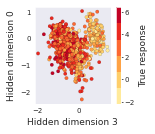

In [13]:
# Do the plotting
from matplotlib.colors import ListedColormap
# Params
cl_axis1 = 3
cl_axis2 = 0
width = 56 / mm_per_inch
height = 50 / mm_per_inch
marker_size = 12
linewidths=.1
edgecolors = "black"

cl_codes_cov = np.cov(cl_codes.detach().numpy(), rowvar=False)
top_2 = cl_codes_cov.diagonal().argsort()[-2:][::-1]
if (cl_axis1 == "max") or (cl_axis2 == "max"):
    cl_axis1, cl_axis2 = top_2[0], top_2[1]
sns.set_style("dark")

plt.figure(figsize=(width, height))
cmap = ListedColormap(sns.color_palette("YlOrRd"))
#plt.title("Cell lines in code space: " + drug_name)
plt.scatter(sampled_cell_lines_codes[cl_axis1], sampled_cell_lines_codes[cl_axis2], 
            c=sampled_cell_lines_codes["True " + str(global_response_metric)].values, s=marker_size, 
            cmap=cmap, linewidths=linewidths, edgecolors=edgecolors)

plt.xlabel("Hidden dimension {}".format(cl_axis1))
plt.ylabel("Hidden dimension {}".format(cl_axis2))

#plt.legend()
plt.grid(False)
clb = plt.colorbar()
clb.set_label("True response")

plt.tight_layout()
#plt.savefig(os.path.join(panels_filepath, "Fig4 Drug cases", "cell_lines_in_code_space_basic-" + str(drug_name) + ".pdf"))
plt.show()

#### Do the plotting - better version

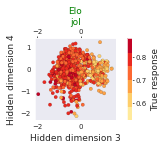

In [55]:
# Do the plotting
from matplotlib.colors import ListedColormap
# Params
cl_axis1 = 3
cl_axis2 = 4
width = 56 / mm_per_inch
height = 50 / mm_per_inch
marker_size = 12
linewidths=.1
edgecolors = "black"

cl_codes_cov = np.cov(cl_codes.detach().numpy(), rowvar=False)
top_2 = cl_codes_cov.diagonal().argsort()[-2:][::-1]
if (cl_axis1 == "max") or (cl_axis2 == "max"):
    cl_axis1, cl_axis2 = top_2[0], top_2[1]
sns.set_style("dark")

fig, ax = plt.subplots(constrained_layout=True)
cmap = ListedColormap(sns.color_palette("YlOrRd"))
plot = ax.scatter(sampled_cell_lines_codes[cl_axis1], sampled_cell_lines_codes[cl_axis2], 
            c=sampled_cell_lines_codes["True " + str(global_response_metric)].values, s=marker_size, 
            cmap=cmap, linewidths=linewidths, edgecolors=edgecolors)

secax = ax.secondary_xaxis('top')
secax.set_xlabel("Elo\njol", color="green")
ax.set_xlabel("Hidden dimension {}".format(cl_axis1))
ax.set_ylabel("Hidden dimension {}".format(cl_axis2))

ax.set_yticks([-2, -1, 0, 1])
clb = fig.colorbar(plot)
clb.set_label("True response")
clb.set_ticks([0.6, 0.7, 0.8 ])

#plt.tight_layout()
#plt.savefig("./Panels/cell_lines_in_code_space-" + str(drug_name) + ".pdf")
plt.show()

In [50]:
secax = ax.secondary_xaxis('top', functions=(deg2rad, rad2deg))
secax.set_xlabel('angle [rad]')

array([0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85])

### Panel 2: Features attributions

In [50]:
# Set up constants
# Size in milimeters
panel_width_mm = 56
panel_height_mm = 50

# Size in inches
panel_width_inch = panel_width_mm / mm_per_inch
panel_height_inch = panel_height_mm / mm_per_inch

print("Width:", panel_width_mm, panel_width_inch)
print("Height:", panel_height_mm, panel_height_inch)

# Update rcParams
params = {
        'figure.figsize'      : [panel_width_inch, panel_height_inch] ,
        'font.size'           : 10      ,
        #'font.sans-serif'     : 'Arial'    ,
        'axes.titlesize'      : 12.       ,
        'axes.labelsize'      : global_axis_label_font_size       ,
        'xtick.major.size'    : 2        ,
        'xtick.major.width'   : 0.75     ,
        'xtick.labelsize'     : 7.0      ,
        'xtick.direction'     : 'out'      ,
        'ytick.major.size'    : 2        ,
        'ytick.major.width'   : 0.75     ,
        'ytick.labelsize'     : 7.0      ,
        'ytick.direction'     : 'out'      ,
        'xtick.major.pad'     : 2        ,
        'xtick.minor.pad'     : 2        ,
        'ytick.major.pad'     : 2        ,
        'ytick.minor.pad'     : 2        ,
        'savefig.dpi'         : global_dpi   ,
        'axes.linewidth'      : 0.75     ,
        'text.usetex'         : False     ,
        'text.latex.unicode'  : False     }

plt.rcParams.update(params)
print(plt.rcParams.get('figure.figsize'))
print(plt.rcParams.get('font.size'))

Width: 56 2.204724409448819
Height: 50 1.968503937007874


/home/krzysztof/anaconda3/envs/modeling_drug_efficacy/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]


[2.204724409448819, 1.968503937007874]
10.0


In [14]:
# Setup paramaters
normalize_feat_imp = False
absolute_attributions = False

# Analyze whole rec system
def net(drug_input, cl_input):
    return retrained_network(drug_input, cl_input)[0]
# Method for calculating the sensitivities
ig = IntegratedGradients(net)

# Establish samples on which to compute importances
samples  = samples_all[samples_all["DRUG_ID"] == drug_id]

cl_input = torch.from_numpy(cell_line_data_df.loc[samples["COSMIC_ID"].values].values).float()
drug_input = torch.from_numpy(drug_data_df.loc[samples["DRUG_ID"].values].values).float()

cl_input.requires_grad_()
drug_input.requires_grad_()

attributions, delta = ig.attribute((drug_input, cl_input), return_convergence_delta=True)
drug_attributions, cl_attributions = attributions
drug_attributions = drug_attributions.detach().numpy()
cl_attributions = cl_attributions.detach().numpy()

drug_attributions_mat = drug_attributions.copy()
cl_attributions_mat = cl_attributions.copy()

print(drug_attributions.shape, (drug_attributions < 0).sum())
print(cl_attributions.shape, (cl_attributions < 0).sum())

# Average the attributions
if absolute_attributions:
    drug_attributions = np.mean(np.abs(drug_attributions), axis=0)
    cl_attributions = np.mean(np.abs(cl_attributions), axis=0)
else:
    drug_attributions = np.mean(drug_attributions, axis=0)
    cl_attributions = np.mean(cl_attributions, axis=0)
    
# Normalize if specified
if normalize_feat_imp:
    drug_attributions = drug_attributions / np.abs(drug_attributions).sum()
    cl_attributions = cl_attributions / np.abs(cl_attributions).sum()
# Connect numbers with feature names
drug_attributions = [x for x in zip(list(drug_data_df.columns), drug_attributions)]
cl_attributions = [x for x in zip(list(cell_line_data_df.columns), cl_attributions)]

all_features_attributions = drug_attributions + cl_attributions
# Sort by importance
drug_attributions = sorted(drug_attributions, key=lambda x: abs(x[1]), reverse=True)
cl_attributions = sorted(cl_attributions, key=lambda x: abs(x[1]), reverse=True)

(862, 294) 119942
(862, 241) 86819


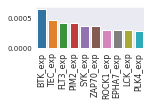

In [18]:
# Do the plotting - cell lines
# Plotting params
k = 10   # How many features to display

width = 56 / mm_per_inch
height = 40 / mm_per_inch
plt.figure(figsize=(width, height))
sns.barplot(x=[x[0] for x in cl_attributions[:k]], y=np.abs([x[1] for x in cl_attributions[:k]]))
#plt.title("Top {} features".format("cell lines'"))
plt.xticks(rotation=90, fontsize=8)

plt.tight_layout()
plt.savefig(os.path.join(panels_filepath, "Fig4 Drug cases", "cell_lines_feat_imps-{}.pdf".format(drug_name)))
plt.show()

In [19]:
drug_name

'NPK76-II-72-1'

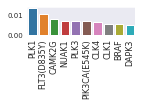

In [20]:
# Do the plotting - drugs
# Plotting params
k = 10   # How many features to display

width = 56 / mm_per_inch
height = 40 / mm_per_inch
plt.figure(figsize=(width, height))
ax = sns.barplot(x=[x[0] for x in drug_attributions[:k]], y=np.abs([x[1] for x in drug_attributions[:k]]))
#plt.title("Top {} features".format("drugs'"))
tick_labels = []
for tick in ax.get_xticklabels():
    if tick._text == "EGFR(L747-E749del, A750P)":
        tick_labels.append("EGFR")
    else:
        tick_labels.append(tick._text)
ax.set_xticklabels(tick_labels)
plt.xticks(rotation=90, fontsize=8)

plt.tight_layout()
plt.savefig(os.path.join(panels_filepath, "Fig4 Drug cases", "drugs_feat_imps-{}.pdf".format(drug_name)))
plt.show()

In [84]:
drug_attributions[:20]  # Absolute

[('MK03', 0.01409773),
 ('CDK9', 0.013070196),
 ('CDK16', 0.010637278),
 ('PHKG1', 0.009733604),
 ('GSK3B', 0.008369498),
 ('GSK3A', 0.00836679),
 ('PAK6', 0.007990365),
 ('ERK3', 0.00607409),
 ('CLK3', 0.005554114),
 ('CDK2', 0.005488615),
 ('KPCD', 0.0049590934),
 ('DYRK1B', 0.004106265),
 ('MP2K3', 0.004088243),
 ('DCLK1', 0.00402961),
 ('CDK14', 0.0037820232),
 ('KPCD1', 0.0037320962),
 ('FLT3(D835H)', 0.0036550618),
 ('FLT3', 0.0035977913),
 ('CLK1', 0.0035215104),
 ('PAK4', 0.0034862605)]

In [88]:
drug_attributions[:20]   # Non-absolute

[('MK03', 0.01409773),
 ('CDK9', -0.013070196),
 ('CDK16', -0.010637278),
 ('PHKG1', 0.009733604),
 ('GSK3B', -0.008369498),
 ('GSK3A', -0.00836679),
 ('PAK6', 0.007990365),
 ('ERK3', 0.00607409),
 ('CLK3', 0.005554114),
 ('CDK2', 0.005488615),
 ('KPCD', 0.0049590934),
 ('DYRK1B', 0.004106265),
 ('MP2K3', 0.004088243),
 ('DCLK1', 0.00402961),
 ('CDK14', -0.0037820232),
 ('KPCD1', 0.0037278254),
 ('FLT3(D835H)', 0.0036550618),
 ('FLT3', -0.0035977913),
 ('CLK1', -0.0035215104),
 ('PAK4', -0.0034862605)]

In [85]:
cl_attributions[:20]   # Absolute

[('BTK_exp', 0.001045641),
 ('CDK16_exp', 0.0010193993),
 ('PLK2_exp', 0.00092796434),
 ('CLK1_exp', 0.0008969684),
 ('MET_exp', 0.00089360087),
 ('SYK_exp', 0.00087485835),
 ('MARK3_exp', 0.00086881436),
 ('PIM2_exp', 0.0008562625),
 ('CDK5_exp', 0.0008309534),
 ('NEK6_exp', 0.0008151499),
 ('RIOK1_exp', 0.0008058293),
 ('SRPK1_exp', 0.0008001183),
 ('NLK_exp', 0.0007919902),
 ('STK33_exp', 0.0007859705),
 ('ROCK1_exp', 0.0007815067),
 ('TEC_exp', 0.0007778261),
 ('MYLK_exp', 0.00077543204),
 ('CSK_exp', 0.0007673407),
 ('LIMK1_exp', 0.0007654439),
 ('AXL_exp', 0.000737935)]

In [89]:
cl_attributions[:20]   # Non absolute

[('BTK_exp', -0.0007964318),
 ('PIM2_exp', -0.00063029234),
 ('TEC_exp', -0.00053947506),
 ('FLT3_exp', -0.00046474146),
 ('SYK_exp', -0.0004338685),
 ('CSK_exp', -0.0004201398),
 ('ROCK1_exp', -0.00038966938),
 ('ZAP70_exp', -0.00038040135),
 ('EGFR_exp', -0.00037219288),
 ('PLK4_exp', -0.00037190018),
 ('DDR1_exp', -0.0003498325),
 ('BLK_exp', -0.0003291202),
 ('LCK_exp', -0.0003250669),
 ('CAMK1D_exp', -0.0003249631),
 ('CSNK1G3_exp', -0.00032323587),
 ('Tissue_leukemia', -0.0003183431),
 ('RET_exp', 0.00031004223),
 ('EPHA7_exp', -0.00030949002),
 ('PLK2_exp', -0.00030845092),
 ('CAMK1G_exp', -0.00029833303)]

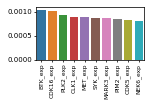

In [62]:
# Do the plotting - cell lines
# Plotting params
k = 10   # How many features to display

width = 56 / mm_per_inch
height = 40 / mm_per_inch
plt.figure(figsize=(width, height))
sns.barplot(x=[x[0] for x in cl_attributions[:k]], y=np.abs([x[1] for x in cl_attributions[:k]]))
#plt.title("Top {} features".format("cell lines'"))
plt.xticks(rotation=90, fontsize=6)

plt.tight_layout()
#plt.savefig(os.path.join(panels_filepath, "Fig4 Drug cases", "cell_lines_feat_imps-" + str(drug_name) + ".pdf"))
plt.show()

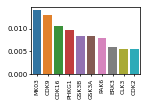

In [63]:
# Do the plotting - drugs
# Plotting params
k = 10   # How many features to display

width = 56 / mm_per_inch
height = 40 / mm_per_inch
plt.figure(figsize=(width, height))
ax = sns.barplot(x=[x[0] for x in drug_attributions[:k]], y=np.abs([x[1] for x in drug_attributions[:k]]))
#plt.title("Top {} features".format("drugs'"))
tick_labels = []
for tick in ax.get_xticklabels():
    if tick._text == "EGFR(L747-E749del, A750P)":
        tick_labels.append("EGFR")
    else:
        tick_labels.append(tick._text)
ax.set_xticklabels(tick_labels)
plt.xticks(rotation=90, fontsize=6)

plt.tight_layout()
#plt.savefig(os.path.join(panels_filepath, "Fig4 Drug cases", "drugs_feat_imps-" + str(drug_name) + ".pdf"))
plt.show()

In [64]:
drug_attributions[:20]

[('MK03', 0.01409773),
 ('CDK9', 0.013070196),
 ('CDK16', 0.010637278),
 ('PHKG1', 0.009733604),
 ('GSK3B', 0.008369498),
 ('GSK3A', 0.00836679),
 ('PAK6', 0.007990365),
 ('ERK3', 0.00607409),
 ('CLK3', 0.005554114),
 ('CDK2', 0.005488615),
 ('KPCD', 0.0049590934),
 ('DYRK1B', 0.004106265),
 ('MP2K3', 0.004088243),
 ('DCLK1', 0.00402961),
 ('CDK14', 0.0037820232),
 ('KPCD1', 0.0037320962),
 ('FLT3(D835H)', 0.0036550618),
 ('FLT3', 0.0035977913),
 ('CLK1', 0.0035215104),
 ('PAK4', 0.0034862605)]

In [68]:
cl_attributions[:20]

[('BTK_exp', 0.001045641),
 ('CDK16_exp', 0.0010193993),
 ('PLK2_exp', 0.00092796434),
 ('CLK1_exp', 0.0008969684),
 ('MET_exp', 0.00089360087),
 ('SYK_exp', 0.00087485835),
 ('MARK3_exp', 0.00086881436),
 ('PIM2_exp', 0.0008562625),
 ('CDK5_exp', 0.0008309534),
 ('NEK6_exp', 0.0008151499),
 ('RIOK1_exp', 0.0008058293),
 ('SRPK1_exp', 0.0008001183),
 ('NLK_exp', 0.0007919902),
 ('STK33_exp', 0.0007859705),
 ('ROCK1_exp', 0.0007815067),
 ('TEC_exp', 0.0007778261),
 ('MYLK_exp', 0.00077543204),
 ('CSK_exp', 0.0007673407),
 ('LIMK1_exp', 0.0007654439),
 ('AXL_exp', 0.000737935)]

### Panel 3: Plot cell line feature vs. response

In [222]:
# Compute predictions and true responses
response_predictions = net(drug_input, cl_input)
samples = general_response_df[["DRUG_ID", "COSMIC_ID", global_response_metric]][
    general_response_df[["DRUG_ID", "COSMIC_ID", global_response_metric]]["DRUG_ID"] == drug_id]
true_response = samples[global_response_metric]

In [223]:
# Widget - cell lines
def plot_response_vs_feat(feature, response):
    x = cell_line_data_original_df.loc[samples["COSMIC_ID"].values][feature]
    if response == "predicted":
        y = response_predictions.detach().numpy().reshape(-1)
    else:
        y = true_response
    plt.figure()
    sns.regplot(x, y)
    plt.title("Response vs {}".format(feature))
    plt.xlabel(feature)
    plt.ylabel(global_response_metric)

interact(plot_response_vs_feat,
feature=[x[0] for x in cl_attributions[:k]],
response=["predicted", "true"])

interactive(children=(Dropdown(description='feature', options=('BTK_exp', 'TEC_exp', 'PIM2_exp', 'ZAP70_exp', …

<function __main__.plot_response_vs_feat(feature, response)>

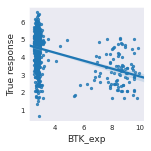

In [224]:
# Figure quality
width = 56 / mm_per_inch
height = 56 /mm_per_inch
marker_size = 5

feature = "BTK_exp"

x = cell_line_data_original_df.loc[samples["COSMIC_ID"].values][feature]
plt.figure(figsize=(width, height))
sns.regplot(x, true_response, scatter_kws={"s": marker_size}, truncate=False)
#plt.title("Response vs {}".format(feature))
plt.xlabel(feature)
plt.ylabel("True response")

plt.tight_layout()
plt.savefig(os.path.join(panels_filepath, "Fig4 Drug cases", "resp_vs_feat-" + str(drug_name) + ".pdf"))
plt.show()

### Panel 4: Response vs. hidden dim

In [21]:
# Set up constants
# Size in milimeters
panel_width_mm = 56
panel_height_mm = 50

# Size in inches
panel_width_inch = panel_width_mm / mm_per_inch
panel_height_inch = panel_height_mm / mm_per_inch

print("Width:", panel_width_mm, panel_width_inch)
print("Height:", panel_height_mm, panel_height_inch)

# Update rcParams
params = {
        'figure.figsize'      : [panel_width_inch, panel_height_inch] ,
        'font.size'           : 10      ,
        #'font.sans-serif'     : 'Arial'    ,
        'axes.titlesize'      : 12.       ,
        'axes.labelsize'      : global_axis_label_font_size       ,
        'xtick.major.size'    : 2        ,
        'xtick.major.width'   : 0.75     ,
        'xtick.labelsize'     : 7.0      ,
        'xtick.direction'     : 'out'      ,
        'ytick.major.size'    : 2        ,
        'ytick.major.width'   : 0.75     ,
        'ytick.labelsize'     : 7.0      ,
        'ytick.direction'     : 'out'      ,
        'xtick.major.pad'     : 2        ,
        'xtick.minor.pad'     : 2        ,
        'ytick.major.pad'     : 2        ,
        'ytick.minor.pad'     : 2        ,
        'savefig.dpi'         : global_dpi   ,
        'axes.linewidth'      : 0.75     ,
        'text.usetex'         : False     ,
        'text.latex.unicode'  : False     }

plt.rcParams.update(params)
print(plt.rcParams.get('figure.figsize'))
print(plt.rcParams.get('font.size'))

Width: 56 2.204724409448819
Height: 50 1.968503937007874


/home/krzysztof/anaconda3/envs/modeling_drug_efficacy/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]


[2.204724409448819, 1.968503937007874]
10.0


In [22]:
# Compute codes and reconstructions for drug an cell lines
# Compute reconstructions for drug
drug_codes, drug_recs = retrained_network.drug_autoencoder(torch.from_numpy(drug_data_df.values).float())
# Create a DataFrame with drugs and their code embeddings
drug_codes_df = pd.DataFrame(drug_codes.detach().numpy(), index=drug_data_df.index)
# Compute reconstructions for all cell lines
cl_codes, cl_recs = retrained_network.cell_line_autoencoder(torch.from_numpy(
    cell_line_data_df.values).float())
# Create a DataFrame with cell lines and their code embeddings
cl_codes_df = pd.DataFrame(cl_codes.detach().numpy(), index=cell_line_data_df.index)
samples = general_response_df[["DRUG_ID", "COSMIC_ID", global_response_metric]][
    general_response_df[["DRUG_ID", "COSMIC_ID", global_response_metric]]["DRUG_ID"] == drug_id]
sampled_cell_lines_codes = cl_codes_df.loc[samples["COSMIC_ID"].values]
sampled_cell_lines_codes["True " + str(global_response_metric)] = samples[global_response_metric].values

In [23]:
# Load the updated enrichment heatmap
def abbreviate_term(t):
    words = t.split(" ")
    abbr_words = [word_abbreviations[w] if w in word_abbreviations else w for w in words]
    return " ".join(abbr_words)

df = pd.read_csv(os.path.join(panels_filepath, "Fig3 GO terms lists", "gsea_heatmap_biol_proc_after_revigo.csv"),
                index_col=0)
with open(os.path.join(panels_filepath, "Fig3 GO terms lists", "word_abbr_dict.pkl"), "rb") as f:
    word_abbreviations = dill.load(f)
print(df.shape, len(word_abbreviations))
df.head(2)

(67, 10) 17


,6,1,2,8,9,3,5,4,0,7
Term,,,,,,,,,,
DNA metabolic process,1.000000e-08,NaN,1.000000e-08,NaN,1.000000e-08,1.000000e-08,NaN,NaN,NaN,NaN
regulation of cellular macromolecule biosynthetic process,1.000000e-08,NaN,NaN,NaN,NaN,1.000000e-08,NaN,NaN,NaN,NaN


In [24]:
# Create a dictionary of dimension: enriched terms
dim_terms_dict = {}
for dim in range(10):
    current_df = df[[str(dim)]]
    pos_terms = list(current_df[current_df[str(dim)] > 0].index)
    neg_terms = list(current_df[current_df[str(dim)] < 0].index)
    pos_terms = [abbreviate_term(t) for t in pos_terms]
    neg_terms = [abbreviate_term(t) for t in neg_terms]    
    dim_terms_dict[dim] = (pos_terms, neg_terms)
print(len(dim_terms_dict))

10


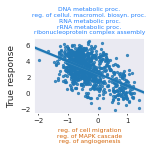

In [62]:
from matplotlib.offsetbox import AnchoredOffsetbox, TextArea, HPacker, VPacker
# Do the plotting
topk_terms = 15
cl_axis = 3
width = 56 / mm_per_inch
height = 56 /mm_per_inch

plt.figure(figsize=(width, height))
ax = sns.regplot(sampled_cell_lines_codes[cl_axis], 
                        sampled_cell_lines_codes["True " + str(global_response_metric)].values,
                        scatter_kws={"s":5}, truncate=False)
ax2 = ax.twiny()
xlabel_top = "\n".join(dim_terms_dict[cl_axis][0][:topk_terms])   # Positive terms (0 index)
xlabel_bottom = "\n".join(dim_terms_dict[cl_axis][1][:topk_terms])   # Negative terms (1 index)

blue = sns.diverging_palette(h_neg=28, h_pos=256, s=99, l=55, sep=7, n=8, center="light")[-1]
brown = sns.diverging_palette(h_neg=28, h_pos=256, s=99, l=55, sep=7, n=8, center="light")[0]

ax.set_xlabel(xlabel_bottom, c=brown, fontsize=6)
ax2.set_xticks([])
ax2.set_xlabel(xlabel_top, c=blue, fontsize=6)
ax.set_ylabel("True response")

plt.tight_layout()
#plt.savefig(os.path.join(panels_filepath, "Fig4 Drug cases", "resp_vs_single_dim-" + str(drug_name) + ".pdf"))
plt.show()

In [25]:
plt.rcParams.update({'figure.autolayout': True})

In [28]:
sns.set_style("whitegrid")

-0.4809983626214211 4.090577959960296e-51


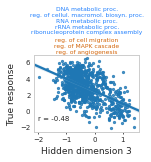

In [31]:
#from matplotlib.offsetbox import AnchoredOffsetbox, TextArea, HPacker, VPacker
# Do the plotting
topk_terms = 15
cl_axis = 3
width = 56 / mm_per_inch
height = 60 /mm_per_inch

fig = plt.figure(figsize=(width, height))
ax = sns.regplot(sampled_cell_lines_codes[cl_axis], 
                        sampled_cell_lines_codes["True " + str(global_response_metric)].values,
                        scatter_kws={"s":5}, truncate=False)

ax2 = ax.twiny()
xlabel_top = "\n".join(dim_terms_dict[cl_axis][0][:topk_terms])   # Positive terms (0 index)
xlabel_top = xlabel_top + "\n"
xlabel_bottom = "\n".join(dim_terms_dict[cl_axis][1][:topk_terms])   # Negative terms (1 index)

blue = sns.diverging_palette(h_neg=28, h_pos=256, s=99, l=55, sep=7, n=8, center="light")[-1]
brown = sns.diverging_palette(h_neg=28, h_pos=256, s=99, l=55, sep=7, n=8, center="light")[0]

# ybox1 = TextArea("Data2-y ", textprops=dict(color="r", size=15,rotation=90,ha='left',va='bottom'))
# ybox2 = TextArea("and ",     textprops=dict(color="k", size=15,rotation=90,ha='left',va='bottom'))
# ybox3 = TextArea("Data1-y ", textprops=dict(color="b", size=15,rotation=90,ha='left',va='bottom'))

# xbox1 = TextArea(xlabel_top, textprops=dict(color="b"))
# xbox2 = TextArea(xlabel_bottom, textprops=dict(color="r"))

# xbox = VPacker(children=[xbox1, xbox2],align="bottom", pad=0, sep=5)

# anchored_xbox = AnchoredOffsetbox(loc=8, child=ybox, pad=0., frameon=False, bbox_to_anchor=(-0.08, 0.4), 
#                                   bbox_transform=ax.transAxes, borderpad=0.)

# ax.add_artist(anchored_xbox)

# Calculate correlation coefficient
corr_metric = "spearman"

if corr_metric == "spearman":
    r, pval = spearmanr(sampled_cell_lines_codes[cl_axis], 
                        sampled_cell_lines_codes["True " + str(global_response_metric)].values)
if corr_metric == "pearson":
    r, pval = pearsonr(sampled_cell_lines_codes[cl_axis], 
                        sampled_cell_lines_codes["True " + str(global_response_metric)].values)

ax2.set_xticks([])
#ax2.set_xlabel(xlabel_top, c=blue, fontsize=6)
ax.set_ylabel("True response", fontsize=global_axis_label_font_size)
ax.set_xlabel("Hidden dimension {}".format(cl_axis), fontsize=global_axis_label_font_size)

#ax.xaxis.set_label_position("top")
ax2.text(0.5, 1.20, xlabel_top, color=blue, transform=ax.transAxes, fontsize=6, ha="center")
ax2.text(0.5, 1.02, xlabel_bottom, color=brown, transform=ax.transAxes, fontsize=6, ha="center")

# Put R on the plot
print(r, pval)
ax.text(-2., -1.2, "r = {:.2f}".format(r), fontsize=7)

ax.grid(False)

plt.tight_layout()
plt.savefig(os.path.join(panels_filepath, 
                         "Fig4 Drug cases", "resp_vs_single_dim-" + str(drug_name) + "v2_.pdf"), bbox_inches="tight")

plt.show()

In [35]:
df = full_dataset.drug_metadata
df.head(2)

,Drug ID,Name,Synonyms,Targets,Target pathway,PubCHEM,Dataset,Sample size,Screening site,Count
0,1242,(5Z)-7-Oxozeaenol,"5Z-7-Oxozeaenol, LL-Z1640-2",TAK1,"Other, kinases",9863776,GDSC1,912,SANGER,495
1,179,5-Fluorouracil,5-FU,Antimetabolite (DNA & RNA),Other,3385,GDSC1,913,MGH,495


In [39]:
df[df["Name"] == "XMD14-99"]

,Drug ID,Name,Synonyms,Targets,Target pathway,PubCHEM,Dataset,Sample size,Screening site,Count
477,253,XMD14-99,NaN,"ALK, CDK7, LTK, others","Other, kinases",none,GDSC1,920,MGH,495


## Figure 5: Linking drugs to processes

### Create a table combining drugs' and cell lines' codes and response

In [8]:
# Load the retrained model
# Establish filepath to the experiment
model_dir = "../Final results/Models retrained on the whole data/One-layer autoencoders, two-layer code forwarding, with data augmentation, MinMaxScaled IC50 - params from experiment 4 - replay/"
# Load model trained with independence loss
with open(os.path.join(model_dir, "retrained_model.pkl"), "rb") as f:
    retrained_model = dill.load(f)
retrained_network = retrained_model.network
print(type(retrained_model), type(retrained_network))
retrained_network.eval()

<class 'modeling.ModelWithAutoencoders'> <class 'architectures.RecSystemCodeConcatenation'>


RecSystemCodeConcatenation(
  (drug_autoencoder): DeepAutoencoderOneHiddenLayer(
    (encoder): Sequential(
      (0): Linear(in_features=294, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=10, bias=True)
    )
    (decoder): Sequential(
      (0): Linear(in_features=10, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=294, bias=True)
    )
  )
  (cell_line_autoencoder): DeepAutoencoderOneHiddenLayer(
    (encoder): Sequential(
      (0): Linear(in_features=241, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=10, bias=True)
    )
    (decoder): Sequential(
      (0): Linear(in_features=10, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=241, bias=True)
    )
  )
  (forward_network): ForwardNetworkTwoHiddenLayers(
    (layers): Sequential(
      (0): Linear(in_features=20, out_features=512, bias=True)


In [9]:
samples = general_response_df[["DRUG_ID", "COSMIC_ID", global_response_metric]]
print(samples.shape)
samples.head(2)

# Compute reconstructions for drugs
drug_codes, drug_recs = retrained_network.drug_autoencoder(torch.from_numpy(drug_data_df.values).float())
# Create a DataFrame with drugs and their code embeddings
drug_codes_df = pd.DataFrame(drug_codes.detach().numpy(), index=drug_data_df.index)
# Compute reconstructions for all cell lines
cl_codes, cl_recs = retrained_network.cell_line_autoencoder(torch.from_numpy(
    cell_line_data_df.values).float())
# Create a DataFrame with cell lines and their code embeddings
cl_codes_df = pd.DataFrame(cl_codes.detach().numpy(), index=cell_line_data_df.index)

# Add prefixex to variable names in cell line and drugs
cl_codes_samples_df = cl_codes_df.copy()
cl_codes_samples_df.columns = cl_codes_samples_df.columns.map(lambda x: "cl" + str(x))
drug_codes_samples_df = drug_codes_df.copy()
drug_codes_samples_df.columns = drug_codes_samples_df.columns.map(lambda x: "dr" + str(x))

samples_with_codes_df = pd.merge(samples, cl_codes_samples_df, left_on="COSMIC_ID", right_on="cell_line_id", how="left")
print(samples_with_codes_df.shape)
samples_with_codes_df = pd.merge(samples_with_codes_df, drug_codes_samples_df, left_on="DRUG_ID", 
                                 right_on="Small Molecule", how="left")
# Add a columns with drug name and target pathway
samples_with_codes_df.insert(1, "Drug Name", samples_with_codes_df["DRUG_ID"].map(full_dataset.gdsc_drug_id_to_gdsc_name_mapper))
samples_with_codes_df.insert(2, "Target Pathway", 
                            samples_with_codes_df["DRUG_ID"].map(full_dataset.drug_gdsc_id_to_target_pathway_mapper))
print(samples_with_codes_df.shape, samples_with_codes_df["LN_IC50"].mean())
samples_with_codes_df.sample(2)

(52730, 3)
(52730, 13)
(52730, 25) 2.0119982754409254


,DRUG_ID,Drug Name,Target Pathway,COSMIC_ID,LN_IC50,cl0,cl1,cl2,cl3,cl4,...,dr0,dr1,dr2,dr3,dr4,dr5,dr6,dr7,dr8,dr9
14961,253,XMD14-99,"Other, kinases",907799,3.449271,0.282655,0.612190,-0.679475,0.874267,-0.710175,...,0.449072,-0.995797,-0.184997,-0.557122,-0.088982,-0.422255,-0.258357,-0.76877,-0.229366,0.075589
26156,332,XMD15-27,"Other, kinases",907321,4.368886,0.211335,0.201621,-0.553344,-0.626522,-0.055085,...,0.227207,-0.962260,0.011724,0.028583,-0.039248,0.055911,-0.968680,-0.60996,-0.090094,0.555691


### Compute drug-cell line dimension table of correlations between response and cell line codes

In [10]:
# Establish type of correlation
corr_metric = "spearman"
# Inititialize the matrix
drug_cl_dim_corr_mat_df = pd.DataFrame(data=np.zeros(shape=(samples_with_codes_df["DRUG_ID"].nunique(), 10)), 
                                       index=pd.Index(samples_with_codes_df["DRUG_ID"].unique(), name="GDSC_drug_ID"),
                                       columns=pd.Index(range(10), name="cl_dim"))
for drug_id in drug_cl_dim_corr_mat_df.index:
    samples_subset = samples_with_codes_df[samples_with_codes_df["DRUG_ID"] == drug_id]
    for dim in range(10):
        cl_dim = "cl" + str(dim)
        cl_vector = samples_subset[cl_dim]
        response_vector = samples_subset["LN_IC50"]
        if corr_metric == "pearson":
            r = pearsonr(cl_vector, response_vector)[0]
        if corr_metric == "spearman":
            r = spearmanr(cl_vector, response_vector)[0]
        # Put corr coefficient into matrix
        drug_cl_dim_corr_mat_df.loc[drug_id, dim] = r
print(drug_cl_dim_corr_mat_df.shape)
drug_cl_dim_corr_mat_df.head()

(74, 10)


cl_dim,0,1,2,3,4,5,6,7,8,9
GDSC_drug_ID,,,,,,,,,,
29,-0.230454,-0.067825,-0.027312,-0.243244,-0.305690,-0.119293,0.220987,0.107216,0.179625,0.045124
35,-0.043960,0.013150,-0.008096,0.039809,-0.066771,0.102058,0.063763,-0.048788,-0.126475,0.056905
53,-0.205044,-0.077917,0.140452,-0.039153,-0.144051,-0.023547,-0.055337,-0.004443,-0.049003,0.233785
54,-0.304065,-0.180230,0.102881,-0.203657,0.003482,-0.098359,0.002562,0.114813,-0.089820,0.169575
55,-0.231964,-0.195728,0.103214,0.047920,-0.223005,-0.058805,-0.106457,0.087670,0.033788,0.118778


In [11]:
print(drug_cl_dim_corr_mat_df.min().min(), drug_cl_dim_corr_mat_df.max().max(),
     drug_cl_dim_corr_mat_df.mean().mean())

-0.5558937183741013 0.3509713228492137 -0.02416777643621666


### Compute drug - biological process table

In [12]:
# Load the enrichment table after revigo
def abbreviate_term(t):
    words = t.split(" ")
    abbr_words = [word_abbreviations[w] if w in word_abbreviations else w for w in words]
    return " ".join(abbr_words)

enrich_df = pd.read_csv(os.path.join(panels_filepath, "Fig3 GO terms lists", "gsea_heatmap_biol_proc_after_revigo_sorted.csv"),
                index_col=0)

with open(os.path.join(panels_filepath, "Fig3 GO terms lists", "word_abbr_dict.pkl"), "rb") as f:
    word_abbreviations = dill.load(f)
enrich_df.index = enrich_df.index.map(abbreviate_term)

print(enrich_df.shape, len(word_abbreviations))
enrich_df.head()

(67, 10) 17


,9,2,6,4,3,5,0,8,1,7
Term,,,,,,,,,,
DNA metabolic proc.,1.000000e-08,1.000000e-08,1.000000e-08,NaN,1.000000e-08,NaN,NaN,NaN,NaN,NaN
reg. of cell cycle G2/M phase trans.,1.000000e-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000e-08,NaN
neutrophil mediated immunity,-1.000000e-08,NaN,-1.000000e-08,1.000000e-08,NaN,NaN,1.000000e-08,-1.000000e-08,1.000000e-08,NaN
pos. reg. of I-kappaB kinase/NF-kappaB signal.,-1.000000e-08,NaN,NaN,1.000000e-08,NaN,NaN,NaN,NaN,NaN,NaN
pos. reg. of NF-kappaB transcr. factor act.,-1.000000e-08,NaN,NaN,NaN,NaN,NaN,4.161226e-03,NaN,NaN,NaN


In [13]:
# Initialize the DataFrame to fill
absolute_corrs = False   # Whether or not take absolute values of correlation
term_cl_dim_corr_df = pd.DataFrame(data=np.zeros((drug_cl_dim_corr_mat_df.shape[0], enrich_df.shape[0])),
                                   index=drug_cl_dim_corr_mat_df.index, columns=enrich_df.index)
for drug_id in drug_cl_dim_corr_mat_df.index:
    for term in enrich_df.index:
        # Get the list of associated dimensions
        row = enrich_df.loc[term]
        dims = [int(x) for x in row[row.notnull()].index]
        # Extract the corresponding R's
        if absolute_corrs:
            corrs = drug_cl_dim_corr_mat_df.loc[drug_id, dims].map(np.abs)
        else:
            corrs = drug_cl_dim_corr_mat_df.loc[drug_id, dims]
        # Put mean correlation into the DataFrame
        term_cl_dim_corr_df.loc[drug_id, term] = corrs.mean()
print(term_cl_dim_corr_df.shape)
term_cl_dim_corr_df.head(2)

(74, 67)


Term,DNA metabolic proc.,reg. of cell cycle G2/M phase trans.,neutrophil mediated immunity,pos. reg. of I-kappaB kinase/NF-kappaB signal.,pos. reg. of NF-kappaB transcr. factor act.,neg. reg. of cytokine production,pos. reg. of MAPK cascade,pos. reg. of intracellular signal transd.,pos. reg. of peptidyl-tyrosine phosphorylation,proteolysis,...,mRNA-cont. ribonucleoprotein complex export from nucl.,metaphase plate congression,peptidyl-lysine modification,"DNA dam. resp., signal transd. by p53 class mediator",pos. reg. of cell cycle arrest,epidermis development,cell-cell junction assembly,reg. of autophagy,plasma membrane bounded cell projection assembly,cilium organization
GDSC_drug_ID,,,,,,,,,,,,,,,,,,,,,
29,-0.001112,-0.011351,-0.026372,-0.130283,-0.092665,0.045124,0.045124,0.045124,0.045124,0.045124,...,0.179625,0.179625,0.179625,-0.067825,-0.067825,0.107216,0.107216,0.107216,0.107216,0.107216
35,0.038095,0.035027,-0.017231,-0.004933,0.006472,0.056905,0.056905,0.056905,0.056905,0.056905,...,-0.126475,-0.126475,-0.126475,0.013150,0.013150,-0.048788,-0.048788,-0.048788,-0.048788,-0.048788


In [14]:
print(term_cl_dim_corr_df.mean().mean(), term_cl_dim_corr_df.min().min(), term_cl_dim_corr_df.max().max())

-0.016430606431810404 -0.5558937183741013 0.3509713228492137


### Plot the drug - biological process table

In [15]:
# Set up plotting params
# Size in milimeters
panel_width_mm = full_page_figure_width_mm / 2
panel_height_mm = 80

# Size in inches
panel_width_inch = panel_width_mm / mm_per_inch
panel_height_inch = panel_height_mm / mm_per_inch

print("Width:", panel_width_mm, panel_width_inch)
print("Height:", panel_height_mm, panel_height_inch)

# Update rcParams
params = {
        'figure.figsize'      : [panel_width_inch, panel_height_inch] ,
        'font.size'           : 10      ,
        #'font.sans-serif'     : 'Arial'    ,
        'axes.titlesize'      : 12.       ,
        'axes.labelsize'      : 9.       ,
        'xtick.major.size'    : 2        ,
        'xtick.major.width'   : 0.75     ,
        'xtick.labelsize'     : 8.0      ,
        'xtick.direction'     : 'out'      ,
        'ytick.major.size'    : 2        ,
        'ytick.major.width'   : 0.75     ,
        'ytick.labelsize'     : 8.0      ,
        'ytick.direction'     : 'out'      ,
        'xtick.major.pad'     : 2        ,
        'xtick.minor.pad'     : 2        ,
        'ytick.major.pad'     : 2        ,
        'ytick.minor.pad'     : 2        ,
        'savefig.dpi'         : global_dpi      ,
        'axes.linewidth'      : 0.75     ,
        'text.usetex'         : False     ,
        'text.latex.unicode'  : False     }
plt.rcParams.update(params)
print(plt.rcParams.get('figure.figsize'))
print(plt.rcParams.get('font.size'))

Width: 85.0 3.346456692913386
Height: 80 3.1496062992125986


/home/krzysztof/anaconda3/envs/modeling_drug_efficacy/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]


[3.346456692913386, 3.1496062992125986]
10.0


In [16]:
# Establish colormap
#sns.choose_diverging_palette()

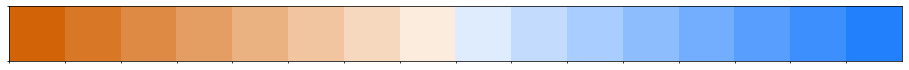

In [17]:
cmap = sns.diverging_palette(h_neg=28, h_pos=256, s=99, l=55, sep=7, n=16, center="light", as_cmap=False)
sns.palplot(cmap)

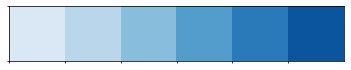

In [18]:
sns.palplot(sns.color_palette("Blues"))

In [91]:
term_cl_dim_corr_df.index = term_cl_dim_corr_df.index.map(full_dataset.gdsc_drug_id_to_gdsc_name_mapper)

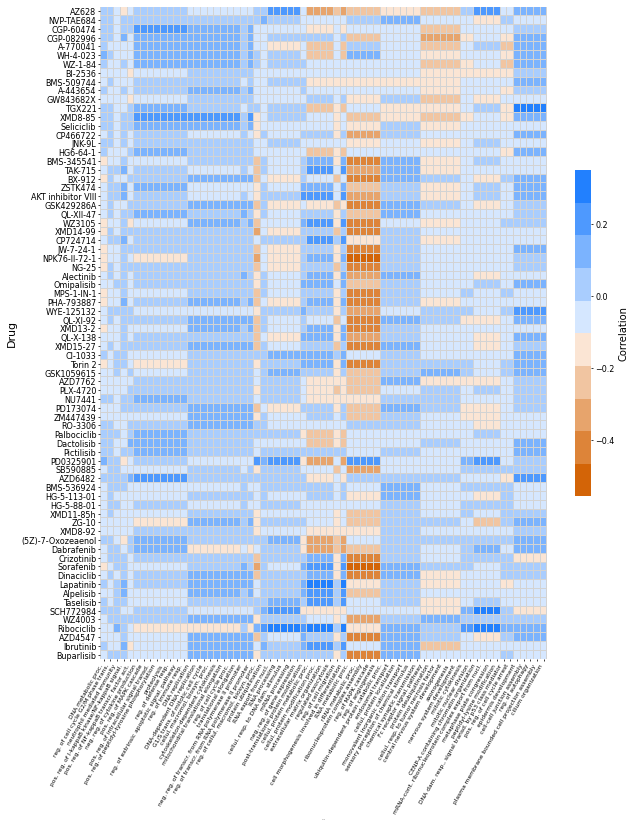

In [92]:
width = 170 / mm_per_inch
height = 120 / mm_per_inch
width = 10
height = 12
ytick_font_size = 8
xtick_font_size = 6
title_font_size = 14
ylabel_size = 11
xlabel_size = 1

plt.figure(figsize=(width, height))
cmap = sns.diverging_palette(h_neg=28, h_pos=256, s=99, l=55, sep=7, n=10, center="light", as_cmap=False)
#cmap = sns.color_palette("vlag")
#cmap = sns.color_palette("Blues")
# Establish max absolute value for color mapping
if term_cl_dim_corr_df.max().max() > np.abs(term_cl_dim_corr_df.min().min()):
    vmax = term_cl_dim_corr_df.max().max()
else:
    vmax = np.abs(term_cl_dim_corr_df.min().min()) 
# Apply term abbreviations
term_cl_dim_corr_df.columns = term_cl_dim_corr_df.columns.map(abbreviate_term)
ax = sns.heatmap(term_cl_dim_corr_df, 
                 yticklabels=True, xticklabels=True, linewidths=0.01, linecolor="lightgray", 
                 cbar_kws={"label": "Correlation", "shrink": 0.5},
                 square=False, cbar=True, cmap=cmap)

ax.figure.axes[-1].yaxis.label.set_size(10)   # Cbar label size
plt.yticks(fontsize=ytick_font_size)
plt.xticks(fontsize=xtick_font_size, rotation=60, ha="right")
plt.ylabel("Drug", fontsize=ylabel_size)
plt.xlabel("Term", fontsize=xlabel_size)
#plt.tight_layout()
# ax.get_figure().savefig(
#     os.path.join("drug-term_heatmap_{}_corr_absolute_{}.pdf".format(corr_metric, absolute_corrs)),
#             bbox_inches="tight")

plt.show()

### Plot the bi-clustered heatmap

#### Testplot

In [19]:
term_cl_dim_corr_df.index = term_cl_dim_corr_df.index.map(full_dataset.gdsc_drug_id_to_gdsc_name_mapper)
term_cl_dim_corr_df.head(2)

Term,DNA metabolic proc.,reg. of cell cycle G2/M phase trans.,neutrophil mediated immunity,pos. reg. of I-kappaB kinase/NF-kappaB signal.,pos. reg. of NF-kappaB transcr. factor act.,neg. reg. of cytokine production,pos. reg. of MAPK cascade,pos. reg. of intracellular signal transd.,pos. reg. of peptidyl-tyrosine phosphorylation,proteolysis,...,mRNA-cont. ribonucleoprotein complex export from nucl.,metaphase plate congression,peptidyl-lysine modification,"DNA dam. resp., signal transd. by p53 class mediator",pos. reg. of cell cycle arrest,epidermis development,cell-cell junction assembly,reg. of autophagy,plasma membrane bounded cell projection assembly,cilium organization
GDSC_drug_ID,,,,,,,,,,,,,,,,,,,,,
AZ628,-0.001112,-0.011351,-0.026372,-0.130283,-0.092665,0.045124,0.045124,0.045124,0.045124,0.045124,...,0.179625,0.179625,0.179625,-0.067825,-0.067825,0.107216,0.107216,0.107216,0.107216,0.107216
NVP-TAE684,0.038095,0.035027,-0.017231,-0.004933,0.006472,0.056905,0.056905,0.056905,0.056905,0.056905,...,-0.126475,-0.126475,-0.126475,0.013150,0.013150,-0.048788,-0.048788,-0.048788,-0.048788,-0.048788


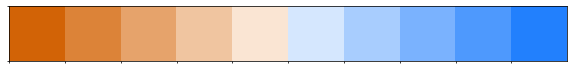

In [20]:
cmap = sns.diverging_palette(h_neg=28, h_pos=256, s=99, l=55, sep=7, n=10, center="light", as_cmap=False)
sns.palplot(cmap)

In [25]:
sns.choose_diverging_palette()

interactive(children=(IntSlider(value=220, description='h_neg', max=359), IntSlider(value=10, description='h_p…

[(0.2519971417644415, 0.4987337088076726, 0.5751602783606602),
 (0.43026136111758173, 0.6200066482697917, 0.6787801878373952),
 (0.6085255804707219, 0.7412795877319109, 0.7824000973141302),
 (0.786789799823862, 0.86255252719403, 0.8860200067908652),
 (0.95, 0.95, 0.95),
 (0.954577257933482, 0.7665309859226215, 0.7803256889894359),
 (0.9197182699854205, 0.5873587656270927, 0.6117400023569117),
 (0.884859282037359, 0.40818654533156384, 0.4431543157243877),
 (0.8510408608937171, 0.23436274952246883, 0.2796010376480583)]

In [31]:
# Set up constants
# Size in milimeters
panel_width_mm = full_page_figure_width_mm / 2
panel_height_mm = 80

# Size in inches
panel_width_inch = panel_width_mm / mm_per_inch
panel_height_inch = panel_height_mm / mm_per_inch

print("Width:", panel_width_mm, panel_width_inch)
print("Height:", panel_height_mm, panel_height_inch)

# Update rcParams
params = {
        'figure.figsize'      : [panel_width_inch, panel_height_inch] ,
        'font.size'           : 10      ,
        #'font.sans-serif'     : 'Arial'    ,
        'axes.titlesize'      : 12.       ,
        'axes.labelsize'      : 9.       ,
        'xtick.major.size'    : 2        ,
        'xtick.major.width'   : 0.75     ,
        'xtick.labelsize'     : 6.0      ,
        'xtick.direction'     : 'out'      ,
        'ytick.major.size'    : 2        ,
        'ytick.major.width'   : 0.75     ,
        'ytick.labelsize'     : 6.0      ,
        'ytick.direction'     : 'out'      ,
        'xtick.major.pad'     : 2        ,
        'xtick.minor.pad'     : 2        ,
        'ytick.major.pad'     : 2        ,
        'ytick.minor.pad'     : 2        ,
        'savefig.dpi'         : global_dpi      ,
        'axes.linewidth'      : 0.75     ,
        'text.usetex'         : False     ,
        'text.latex.unicode'  : False     }

plt.rcParams.update(params)
print(plt.rcParams.get('figure.figsize'))
print(plt.rcParams.get('font.size'))

Width: 85.0 3.346456692913386
Height: 80 3.1496062992125986


/home/krzysztof/anaconda3/envs/modeling_drug_efficacy/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]


[3.346456692913386, 3.1496062992125986]
10.0


/home/krzysztof/anaconda3/envs/modeling_drug_efficacy/lib/python3.6/site-packages/seaborn/matrix.py:1201: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


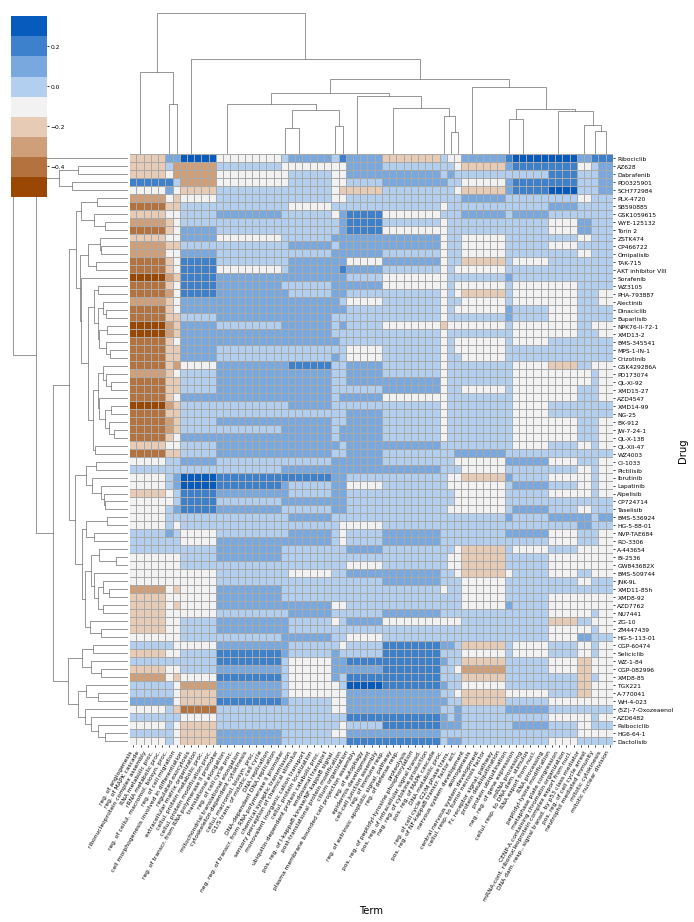

In [101]:
width = 10
height = 14
method = "average"
distance = "euclidean"
axis_label_size = 10
cbar_tick_font_size = 6
xtick_label_size = 6
ytick_label_size = 6

cmap = sns.diverging_palette(h_neg=28, h_pos=256, s=99, l=40, sep=7, n=9, center="light", as_cmap=False)
grid = sns.clustermap(term_cl_dim_corr_df, method=method, metric=distance, figsize=(width, height),
                     cmap=cmap, yticklabels=True, xticklabels=True, square=True, linecolor="darkgray",
                     linewidths=0.01, cbar_kws={"shrink": 0.1})
grid.cax.tick_params(labelsize=cbar_tick_font_size, rotation=0)
grid.ax_heatmap.set_xlabel("Term", fontsize=axis_label_size)
grid.ax_heatmap.set_ylabel("Drug", fontsize=axis_label_size)
grid.ax_heatmap.set_xticklabels(grid.ax_heatmap.get_xticklabels(), rotation=60, ha="right", fontsize=xtick_label_size)
grid.ax_heatmap.set_yticklabels(grid.ax_heatmap.get_yticklabels(), fontsize=ytick_label_size)


plt.show()

In [51]:
grid.ax_heatmap.set_xticklabels()

<a list of 67 Text major ticklabel objects>

In [ ]:
# Overwrite some plotting params
width = full_page_figure_width_mm / (4 * mm_per_inch)
height = 220 / mm_per_inch
axis_label_size = 9
cbar_tick_font_size = 6
title_size = 12

#pos = (0.92, 0.61, 0.05, 0.18)
# Plot clustermap using seaborn
grid = sns.clustermap(drug_code_attributions_df.iloc[:, :-1], method="ward", metric="euclidean", row_linkage=None,
                      col_cluster=False, 
                      row_colors=[drug_feat_color_map[x] for x in drug_code_attributions_df.index], 
                      yticklabels=True, mask=None,
                      figsize=(width, height),
                      cbar_kws={})
# Set heatmap params
#grid.ax_heatmap.set_title("Features-code attributions - drugs", fontsize=title_size)
grid.ax_heatmap.set_xlabel("Hidden dimension", fontsize=axis_label_size)
grid.ax_heatmap.set_ylabel("", fontsize=axis_label_size)

# Modify colorbar and get rid of the gap at the top
grid.cax.set_visible(False)
grid.cax.tick_params(labelsize=cbar_tick_font_size, rotation=0)
grid.ax_col_dendrogram.set_visible(False)

for ytick in grid.ax_heatmap.get_yticklabels():
    color = drug_feat_color_map[ytick._text]
    ytick.set_color(color)

grid.savefig(os.path.join(panels_filepath, "Fig2-drugs_clustermap_half_page.pdf"))
plt.show()

In [ ]:
# Overwrite some plotting params
width = full_page_figure_width_mm / (2 * mm_per_inch)
height = 120 / mm_per_inch
axis_label_size = 9
cbar_tick_font_size = 6
title_size = 12

pos = (0.92, 0.61, 0.05, 0.18)
# Plot clustermap using seaborn
grid = sns.clustermap(drug_code_attributions_df.iloc[:, :-1], method="ward", metric="euclidean", row_linkage=None,
                      col_cluster=False, 
                      row_colors=[drug_feat_color_map[x] for x in drug_code_attributions_df.index], 
                      yticklabels=False, mask=None,
                      figsize=(width, height),
                      cbar_pos=pos,
                      cbar_kws={})
# Set heatmap params
#grid.ax_heatmap.set_title("Features-code attributions - drugs", fontsize=title_size)
grid.ax_heatmap.set_xlabel("Hidden dimension", fontsize=axis_label_size)
grid.ax_heatmap.set_ylabel("Drug feature", fontsize=axis_label_size)

# Modify colorbar and get rid of the gap at the top
#grid.cax.set_visible(False)
grid.cax.tick_params(labelsize=cbar_tick_font_size, rotation=0)
grid.ax_col_dendrogram.set_visible(False)

for ytick in grid.ax_heatmap.get_yticklabels():
    color = drug_feat_color_map[ytick._text]
    ytick.set_color(color)

grid.savefig(os.path.join(panels_filepath, "Fig2-drugs_clustermap.pdf"))
plt.show()

#### Paper plot

In [58]:
# Set up plotting params
# Size in milimeters
panel_width_mm = full_page_figure_width_mm / 2
panel_height_mm = 80

# Size in inches
panel_width_inch = panel_width_mm / mm_per_inch
panel_height_inch = panel_height_mm / mm_per_inch

print("Width:", panel_width_mm, panel_width_inch)
print("Height:", panel_height_mm, panel_height_inch)

# Update rcParams
params = {
        'figure.figsize'      : [panel_width_inch, panel_height_inch] ,
        'font.size'           : 10      ,
        #'font.sans-serif'     : 'Arial'    ,
        'axes.titlesize'      : 12.       ,
        'axes.labelsize'      : 9.       ,
        'xtick.major.size'    : 2        ,
        'xtick.major.width'   : 0.75     ,
        'xtick.labelsize'     : 8.0      ,
        'xtick.direction'     : 'out'      ,
        'ytick.major.size'    : 2        ,
        'ytick.major.width'   : 0.75     ,
        'ytick.labelsize'     : 8.0      ,
        'ytick.direction'     : 'out'      ,
        'xtick.major.pad'     : 2        ,
        'xtick.minor.pad'     : 2        ,
        'ytick.major.pad'     : 2        ,
        'ytick.minor.pad'     : 2        ,
        'savefig.dpi'         : global_dpi      ,
        'axes.linewidth'      : 0.75     ,
        'text.usetex'         : False     ,
        'text.latex.unicode'  : False     }
plt.rcParams.update(params)
print(plt.rcParams.get('figure.figsize'))
print(plt.rcParams.get('font.size'))

Width: 85.0 3.346456692913386
Height: 80 3.1496062992125986


/home/krzysztof/anaconda3/envs/modeling_drug_efficacy/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]


[3.346456692913386, 3.1496062992125986]
10.0


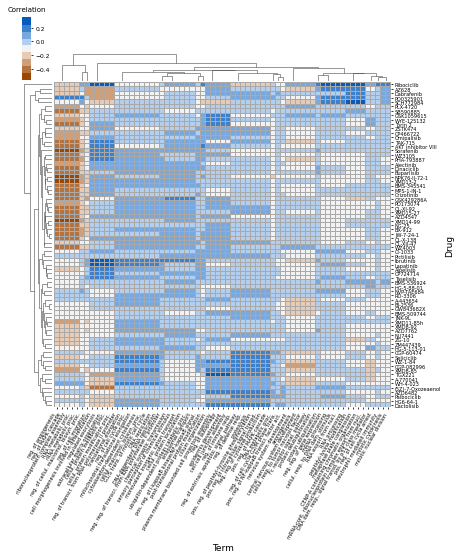

In [117]:
width = 170 / mm_per_inch
height = 220 / mm_per_inch

method = "average"
distance = "euclidean"

axis_label_size = global_axis_label_font_size
cbar_tick_font_size = 6
xtick_label_size = 5
ytick_label_size = 5

cmap = sns.diverging_palette(h_neg=28, h_pos=256, s=99, l=40, sep=7, n=9, center="light", as_cmap=False)

cbar_pos=(0.02, 0.8, 0.05, 0.18)
cbar_pos=(0.02, 0.94, 0.02, 0.10)

grid = sns.clustermap(term_cl_dim_corr_df, method=method, metric=distance, figsize=(width, height),
                     cmap=cmap, yticklabels=True, xticklabels=True, linecolor="darkgray",
                     linewidths=0.01, dendrogram_ratio=(0.08, 0.08), cbar_pos=cbar_pos,
                     cbar_kws={"shrink": 0.1})

grid.cax.tick_params(labelsize=cbar_tick_font_size, rotation=0)
grid.cax.set_title("Correlation", fontsize=7)
grid.ax_heatmap.set_xlabel("Term", fontsize=axis_label_size)
grid.ax_heatmap.set_ylabel("Drug", fontsize=axis_label_size)
grid.ax_heatmap.set_xticklabels(grid.ax_heatmap.get_xticklabels(), rotation=60, ha="right", fontsize=xtick_label_size)
grid.ax_heatmap.set_yticklabels(grid.ax_heatmap.get_yticklabels(), fontsize=ytick_label_size)

grid.savefig(os.path.join(panels_filepath, "Fig5-drugs-process_clustermap_bi_clustering.pdf"))

plt.show()

In [116]:
os.path.join(panels_filepath, "Fig5-drugs-process_clustermap_bi_clustering.pdf")

'./BMC/Panels/Fig5-drugs-process_clustermap_bi_clustering.pdf'

### Plot the heatmap with only row clustering

#### Paper plot

In [118]:
# Set up plotting params
# Size in milimeters
panel_width_mm = full_page_figure_width_mm / 2
panel_height_mm = 80

# Size in inches
panel_width_inch = panel_width_mm / mm_per_inch
panel_height_inch = panel_height_mm / mm_per_inch

print("Width:", panel_width_mm, panel_width_inch)
print("Height:", panel_height_mm, panel_height_inch)

# Update rcParams
params = {
        'figure.figsize'      : [panel_width_inch, panel_height_inch] ,
        'font.size'           : 10      ,
        #'font.sans-serif'     : 'Arial'    ,
        'axes.titlesize'      : 12.       ,
        'axes.labelsize'      : 9.       ,
        'xtick.major.size'    : 2        ,
        'xtick.major.width'   : 0.75     ,
        'xtick.labelsize'     : 8.0      ,
        'xtick.direction'     : 'out'      ,
        'ytick.major.size'    : 2        ,
        'ytick.major.width'   : 0.75     ,
        'ytick.labelsize'     : 8.0      ,
        'ytick.direction'     : 'out'      ,
        'xtick.major.pad'     : 2        ,
        'xtick.minor.pad'     : 2        ,
        'ytick.major.pad'     : 2        ,
        'ytick.minor.pad'     : 2        ,
        'savefig.dpi'         : global_dpi      ,
        'axes.linewidth'      : 0.75     ,
        'text.usetex'         : False     ,
        'text.latex.unicode'  : False     }
plt.rcParams.update(params)
print(plt.rcParams.get('figure.figsize'))
print(plt.rcParams.get('font.size'))

Width: 85.0 3.346456692913386
Height: 80 3.1496062992125986


/home/krzysztof/anaconda3/envs/modeling_drug_efficacy/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]


[3.346456692913386, 3.1496062992125986]
10.0


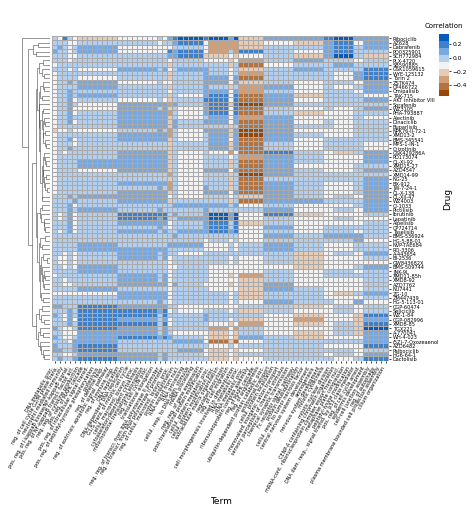

In [137]:
width = 170 / mm_per_inch
height = 220 / mm_per_inch

method = "average"
distance = "euclidean"

axis_label_size = global_axis_label_font_size
cbar_tick_font_size = 6
xtick_label_size = 5
ytick_label_size = 5

cmap = sns.diverging_palette(h_neg=28, h_pos=256, s=99, l=40, sep=7, n=9, center="light", as_cmap=False)

cbar_pos=(0.02, 0.8, 0.05, 0.18)
cbar_pos=(0.89, 0.84, 0.02, 0.10)

grid = sns.clustermap(term_cl_dim_corr_df, method=method, metric=distance, figsize=(width, height),
                     cmap=cmap, yticklabels=True, xticklabels=True, linecolor="darkgray",
                     linewidths=0.01, dendrogram_ratio=(0.08, 0.08), cbar_pos=cbar_pos, 
                      col_cluster=False)

grid.cax.tick_params(labelsize=cbar_tick_font_size, rotation=0)
grid.cax.set_title("Correlation", fontsize=7)
grid.ax_heatmap.set_xlabel("Term", fontsize=axis_label_size)
grid.ax_heatmap.set_ylabel("Drug", fontsize=axis_label_size)
grid.ax_heatmap.set_xticklabels(grid.ax_heatmap.get_xticklabels(), rotation=60, ha="right", fontsize=xtick_label_size)
grid.ax_heatmap.set_yticklabels(grid.ax_heatmap.get_yticklabels(), fontsize=ytick_label_size)

grid.savefig(os.path.join(panels_filepath, "Fig5-drugs-process_clustermap_only_row_clustering.pdf"))

plt.show()

In [124]:
def abbreviate_term(t):
    words = t.split(" ")
    abbr_words = [word_abbreviations[w] if w in word_abbreviations else w for w in words]
    return " ".join(abbr_words)

enrich_df = pd.read_csv(os.path.join(panels_filepath, "Fig3 GO terms lists", "gsea_heatmap_biol_proc_after_revigo_sorted.csv"),
                index_col=0)
with open(os.path.join(panels_filepath, "Fig3 GO terms lists", "word_abbr_dict.pkl"), "rb") as f:
    word_abbreviations = dill.load(f)
    
enrich_df.index = enrich_df.index.map(abbreviate_term)
print(enrich_df.shape, len(word_abbreviations))
enrich_df.head(2)

(67, 10) 17


,9,2,6,4,3,5,0,8,1,7
Term,,,,,,,,,,
DNA metabolic proc.,1.000000e-08,1.000000e-08,1.000000e-08,NaN,1.000000e-08,NaN,NaN,NaN,NaN,NaN
reg. of cell cycle G2/M phase trans.,1.000000e-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000e-08,NaN


In [128]:
enrich_df.index[-5:]

Index(['epidermis development', 'cell-cell junction assembly',
       'reg. of autophagy', 'plasma membrane bounded cell projection assembly',
       'cilium organization'],
      dtype='object', name='Term')

In [127]:
term_cl_dim_corr_df.columns[-5:]

Index(['epidermis development', 'cell-cell junction assembly',
       'reg. of autophagy', 'plasma membrane bounded cell projection assembly',
       'cilium organization'],
      dtype='object', name='Term')

## Optional: Additional drugs-cell lines visualization

In [20]:
import plotly.express as px

### Create a table combining drugs' and cell lines' codes and response

In [21]:
# Load the retrained model
# Establish filepath to the experiment
model_dir = "../Final results/Models retrained on the whole data/One-layer autoencoders, two-layer code forwarding, with data augmentation, MinMaxScaled IC50 - params from experiment 4 - replay/"
# Load model trained with independence loss
with open(os.path.join(model_dir, "retrained_model.pkl"), "rb") as f:
    retrained_model = dill.load(f)
retrained_network = retrained_model.network
print(type(retrained_model), type(retrained_network))
retrained_network.eval()

<class 'modeling.ModelWithAutoencoders'> <class 'architectures.RecSystemCodeConcatenation'>


RecSystemCodeConcatenation(
  (drug_autoencoder): DeepAutoencoderOneHiddenLayer(
    (encoder): Sequential(
      (0): Linear(in_features=294, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=10, bias=True)
    )
    (decoder): Sequential(
      (0): Linear(in_features=10, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=294, bias=True)
    )
  )
  (cell_line_autoencoder): DeepAutoencoderOneHiddenLayer(
    (encoder): Sequential(
      (0): Linear(in_features=241, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=10, bias=True)
    )
    (decoder): Sequential(
      (0): Linear(in_features=10, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=241, bias=True)
    )
  )
  (forward_network): ForwardNetworkTwoHiddenLayers(
    (layers): Sequential(
      (0): Linear(in_features=20, out_features=512, bias=True)


In [22]:
samples = general_response_df[["DRUG_ID", "COSMIC_ID", global_response_metric]]
print(samples.shape)
samples.head(2)

# Compute reconstructions for drugs
drug_codes, drug_recs = retrained_network.drug_autoencoder(torch.from_numpy(drug_data_df.values).float())
# Create a DataFrame with drugs and their code embeddings
drug_codes_df = pd.DataFrame(drug_codes.detach().numpy(), index=drug_data_df.index)
# Compute reconstructions for all cell lines
cl_codes, cl_recs = retrained_network.cell_line_autoencoder(torch.from_numpy(
    cell_line_data_df.values).float())
# Create a DataFrame with cell lines and their code embeddings
cl_codes_df = pd.DataFrame(cl_codes.detach().numpy(), index=cell_line_data_df.index)

# Add prefixex to variable names in cell line and drugs
cl_codes_samples_df = cl_codes_df.copy()
cl_codes_samples_df.columns = cl_codes_samples_df.columns.map(lambda x: "cl" + str(x))
drug_codes_samples_df = drug_codes_df.copy()
drug_codes_samples_df.columns = drug_codes_samples_df.columns.map(lambda x: "dr" + str(x))

samples_with_codes_df = pd.merge(samples, cl_codes_samples_df, left_on="COSMIC_ID", right_on="cell_line_id", how="left")
print(samples_with_codes_df.shape)
samples_with_codes_df = pd.merge(samples_with_codes_df, drug_codes_samples_df, left_on="DRUG_ID", 
                                 right_on="Small Molecule", how="left")
# Add a columns with drug name and target pathway
samples_with_codes_df.insert(1, "Drug Name", samples_with_codes_df["DRUG_ID"].map(full_dataset.gdsc_drug_id_to_gdsc_name_mapper))
samples_with_codes_df.insert(2, "Target Pathway", 
                            samples_with_codes_df["DRUG_ID"].map(full_dataset.drug_gdsc_id_to_target_pathway_mapper))
print(samples_with_codes_df.shape)
samples_with_codes_df.head(2)

(52730, 3)
(52730, 13)
(52730, 25)


,DRUG_ID,Drug Name,Target Pathway,COSMIC_ID,LN_IC50,cl0,cl1,cl2,cl3,cl4,...,dr0,dr1,dr2,dr3,dr4,dr5,dr6,dr7,dr8,dr9
0,29,AZ628,ERK MAPK signaling,683665,2.055377,0.283071,0.228074,0.269422,0.971802,0.356945,...,-0.331994,-0.60955,0.447747,0.206255,-0.475143,-0.044641,1.308036,-0.229407,-0.29699,-0.036197
1,29,AZ628,ERK MAPK signaling,684055,2.070470,-0.914473,-1.259506,0.190483,0.260864,-0.066572,...,-0.331994,-0.60955,0.447747,0.206255,-0.475143,-0.044641,1.308036,-0.229407,-0.29699,-0.036197


### Visualization: bivariatianal scatter plots of single cell line's and drug's dimension colored by response

#### General

In [177]:
#df = samples_with_codes_df.sample(30000)

In [180]:
down_dim = 5
top_dim = 10
dr_increment = 5
cl_increment = 0
fig, ax = plt.subplots(5, 5, figsize=(30, 30))
for i in range(0, 5):
    for j in range(0, 5):
        ax[i][j].scatter(samples_with_codes_df["cl" + str(i + cl_increment)], samples_with_codes_df["dr" + str(j + dr_increment)], 
                         c=samples_with_codes_df["LN_IC50"], s=15)
        ax[i][j].set_xlabel("cl" + str(i + cl_increment), fontsize=14)
        ax[i][j].set_ylabel("dr" + str(j + dr_increment), fontsize=14)
        ax[i][j].tick_params("both", labelsize=12)
fig.savefig("pair_plot_4.pdf")
plt.close()

In [ ]:
plt.scatter(df["cl" + str(4)], df["dr" + str(4)], c=df["LN_IC50"], s=15)
plt.show()

In [27]:
samples_with_codes_df.sample(2)

,DRUG_ID,Drug Name,Target Pathway,COSMIC_ID,LN_IC50,cl0,cl1,cl2,cl3,cl4,...,dr0,dr1,dr2,dr3,dr4,dr5,dr6,dr7,dr8,dr9
25041,331,QL-X-138,"Other, kinases",724838,0.492539,-0.462064,0.097770,0.293206,-0.288600,0.369476,...,-0.000514,-0.259660,0.595777,0.252269,0.304748,-0.193099,-0.188916,-0.030783,0.597807,-0.063366
30415,1036,PLX-4720,ERK MAPK signaling,907056,3.732895,0.314178,-0.539008,-0.049706,0.506226,-0.357572,...,-0.049809,-0.402435,-0.244219,0.338390,-0.365597,-0.156485,0.106421,-0.581328,0.311962,1.308506


In [28]:
name = "Sorafenib"
print(full_dataset.gdsc_name_to_gdsc_id_mapper[name])

1085


#### Per specific dimensions

In [23]:
ranges_dict = {}
for dim in ["cl" + str(x) for x in range(10)] + ["dr" + str(y) for y in range(10)]:
    mini, maxi = samples_with_codes_df[dim].min(), samples_with_codes_df[dim].max()
    ranges_dict[dim] = [mini, maxi]

In [25]:
def plot_dr_dim_vs_cl_dim(dr_dim, cl_dim, sample_size, drugs_subset):
    if sample_size:
        df = samples_with_codes_df.sample(sample_size)
    else:
        df = samples_with_codes_df.copy()
    if drugs_subset:
        drugs_subset = [int(x) for x in drugs_subset.split(";")]
        df = df[df["DRUG_ID"].isin(drugs_subset)]
    # Interactive plot
    fig = px.scatter(df, x="cl" + str(cl_dim), y="dr" + str(dr_dim), color="LN_IC50", 
                     hover_data=["Drug Name", "COSMIC_ID", "Target Pathway"])

    fig.update_traces(marker=dict(size=6))
    fig.update_xaxes(range=ranges_dict["cl" + str(cl_dim)])
    fig.update_yaxes(range=ranges_dict["dr" + str(dr_dim)])
    fig.show()
    
plot_dr_dim_vs_cl_dim_widget = interactive(plot_dr_dim_vs_cl_dim,
                                          dr_dim=[x for x in range(10)],
                                          cl_dim=[x for x in range(10)],
                                          sample_size=[None, 100],
                                          drugs_subset="")

display(plot_dr_dim_vs_cl_dim_widget)

interactive(children=(Dropdown(description='dr_dim', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9), value=0), Dropdow…

### Visualization: parallel coordinates plot: all pairs

In [92]:
df = samples_with_codes_df.sample(20000)
df = samples_with_codes_df.copy()

In [26]:
# cl_dims = ["cl" + str(x) for x in range(10)]
# dr_dims = ["dr" + str(y) for y in range(10)]
# fig = px.parallel_coordinates(df, color="LN_IC50",
#                               dimensions=cl_dims + dr_dims,
#                               color_continuous_midpoint=2)
# fig.show()

#### Group the data, i.e. extract just the points with good response

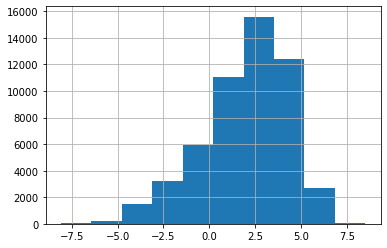

In [72]:
samples_with_codes_df["LN_IC50"].hist()

In [101]:
response_threshold = -5.
good_response_samples_with_codes_df = samples_with_codes_df[samples_with_codes_df["LN_IC50"] < response_threshold]
print(good_response_samples_with_codes_df.shape, good_response_samples_with_codes_df["DRUG_ID"].nunique())

(169, 23) 11


In [110]:
good_response_samples_with_codes_df.iloc[0] = samples_with_codes_df.max()
good_response_samples_with_codes_df.iloc[1] = samples_with_codes_df.min()

/home/krzysztof/.local/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [27]:
# cl_dims = ["cl" + str(x) for x in range(10)]
# dr_dims = ["dr" + str(y) for y in range(10)]
# fig = px.parallel_coordinates(good_response_samples_with_codes_df, color="LN_IC50",
#                               dimensions=cl_dims + dr_dims,
#                               color_continuous_midpoint=2)
# fig.show()

#### Subset of cl and dr dims

In [210]:
def plot_parallel_dims(dr_dims, cl_dims, sample_size, drugs_subset, cl_subset):
    if sample_size:
        df = samples_with_codes_df.sample(sample_size)
    else:
        df = samples_with_codes_df.copy()
    if drugs_subset:
        drugs_subset = [int(x) for x in drugs_subset.split(";")]
        df = df[df["DRUG_ID"].isin(drugs_subset)]
    if cl_subset:
        cl_subset = [int(x) for x in cl_subset.split(";")]
        df = df[df["COSMIC_ID"].isin(cl_subset)]
    
    # Interactive plot
    # Establish variables
    dr_dims = ["dr" + x for x in dr_dims.split(";")]
    cl_dims = ["cl" + x for x in cl_dims.split(";")]
    fig = px.parallel_coordinates(df, color="LN_IC50",
                              dimensions=["COSMIC_ID", "DRUG_ID"] + cl_dims + dr_dims)
    fig.show()
    
plot_parallel_dims_widget = interactive(plot_parallel_dims,
                                          dr_dims="1",
                                          cl_dims="1",
                                          sample_size=[None, 100],
                                          drugs_subset="",
                                          cl_subset="")

display(plot_parallel_dims_widget)

interactive(children=(Text(value='1', description='dr_dims'), Text(value='1', description='cl_dims'), Dropdown…

In [214]:
name = "Dabrafenib"
samples_with_codes_df[
    samples_with_codes_df["Drug Name"] == name]["DRUG_ID"].iloc[0]

1373

### Visualization: parallel coordinates plot: per drug or cell line

## Results: Get the training performance of the retrained model

#### Load the retrained model

In [116]:
# Load the retrained model
# Establish filepath to the experiment
model_dir = "../Final results/Models retrained on the whole data/One-layer autoencoders, two-layer code forwarding, with data augmentation, MinMaxScaled IC50 - params from experiment 4 - replay/"
# Load model trained with independence loss
with open(os.path.join(model_dir, "retrained_model.pkl"), "rb") as f:
    retrained_model = dill.load(f)
retrained_network = retrained_model.network
print(type(retrained_model), type(retrained_network))

<class 'modeling.ModelWithAutoencoders'> <class 'architectures.RecSystemCodeConcatenation'>


In [117]:
samples_all.head(2)

,DRUG_ID,COSMIC_ID,LN_IC50
2748,29,683665,0.611485
2749,29,684055,0.612394


In [118]:
type(retrained_model)

modeling.ModelWithAutoencoders

#### Evaluate

In [122]:
# Evaluation on the training data
import warnings
warnings.filterwarnings("ignore")
samples = samples_all.copy()
print("Training data evaluation")
print()
retrained_model.network.eval()
predicted, y_true, drug_input, cl_input = retrained_model.predict(samples, cell_line_data_df,
                                                           drug_data_df, response_metric=global_response_metric)
response_preds, drug_rec_preds, cl_rec_preds = predicted
print(response_preds.shape, y_true.shape, drug_input.shape, cl_input.shape)

# Create a dataframe with samples and corresponding predictions
samples_with_predictions_df = samples.copy()
samples_with_predictions_df.insert(3, "Predicted AUC", response_preds.reshape(-1).cpu())
print(samples_with_predictions_df.shape)

# Evaluate predictions numerically
rmse, corr = Model.evaluate_predictions(y_true, response_preds.cpu().numpy().reshape(-1))
print("Response prediction performance:")
print("RMSE: {}, Corr.: {}".format(rmse, corr))

# Per-drug performance
per_drug_performance_df = Model.per_drug_performance_df(samples, response_preds.cpu(), response_metric=global_response_metric)
per_drug_performance_df.insert(1, "Drug name", per_drug_performance_df["Drug ID"].map(
    full_dataset.gdsc_drug_id_to_gdsc_name_mapper))
print(per_drug_performance_df.shape)
per_drug_performance_df = per_drug_performance_df.sort_values("Model correlation", ascending=False)
print("Per drug median RMSE and correlation:", per_drug_performance_df["Model RMSE"].median(),
     per_drug_performance_df["Model correlation"].median())
print()


# Evaluate reconstruction predictions
# Metrics calculated on whole matrix
if retrained_model.__class__ == ModelWithAutoencoders:
    rmse, corr = Model.evaluate_predictions(drug_input.ravel(), drug_rec_preds.cpu().numpy().ravel())
    print("Reconstruction performance:")
    print("Whole drug data RMSE and correlation:", np.round(rmse, 3), corr)
    rmse, corr = Model.evaluate_predictions(cl_input.ravel(), cl_rec_preds.cpu().numpy().ravel())
    print("Whole cell line data RMSE and correlation:", np.round(rmse, 3), corr)

per_drug_performance_df.head(10)

Training data evaluation

torch.Size([52730, 1]) (52730,) (52730, 294) (52730, 241)
(52730, 4)
Response prediction performance:
RMSE: 0.0931131158275102, Corr.: (0.8494376252014121, 0.0)
(74, 7)
Per drug median RMSE and correlation: 0.0940516620620615 0.520892158115996

Reconstruction performance:
Whole drug data RMSE and correlation: 0.1 (0.9947810013442425, 0.0)
Whole cell line data RMSE and correlation: 0.608 (0.7509393475217493, 0.0)


,Drug ID,Drug name,Model RMSE,Model correlation,Dummy RMSE,Dummy correlation,No. samples
61,1373,Dabrafenib,0.111935,0.703602,0.118678,NaN,827
33,301,PHA-793887,0.122118,0.694441,0.123205,NaN,863
25,253,XMD14-99,0.098081,0.694319,0.058324,NaN,865
28,257,NPK76-II-72-1,0.109477,0.688450,0.103012,NaN,862
36,330,XMD13-2,0.097362,0.654173,0.079094,NaN,864
19,222,BX-912,0.106262,0.650388,0.105523,NaN,862
63,1085,Sorafenib,0.083589,0.650016,0.079461,NaN,723
29,260,NG-25,0.095720,0.647752,0.102850,NaN,863
35,329,QL-XI-92,0.100787,0.638657,0.077203,NaN,865
51,1060,PD0325901,0.096853,0.635873,0.115626,NaN,881


In [125]:
# Save the per drug performance df
os.listdir(os.path.join(model_dir))
per_drug_performance_df.to_csv(os.path.join(model_dir, "train_performance_per_drug_df.csv"), index=False)

#### Load and show training performance per drug

In [15]:
per_drug_performance_df = pd.read_csv(os.path.join(model_dir, "train_performance_per_drug_df.csv"))
print(per_drug_performance_df.shape)

(74, 7)


In [164]:
per_drug_performance_df.head(20)

,Drug ID,Drug name,Model RMSE,Model correlation,Dummy RMSE,Dummy correlation,No. samples
0,1373,Dabrafenib,0.111935,0.703602,0.118678,NaN,827
1,301,PHA-793887,0.122118,0.694441,0.123205,NaN,863
2,253,XMD14-99,0.098081,0.694319,0.058324,NaN,865
3,257,NPK76-II-72-1,0.109477,0.688450,0.103012,NaN,862
4,330,XMD13-2,0.097362,0.654173,0.079094,NaN,864
5,222,BX-912,0.106262,0.650388,0.105523,NaN,862
6,1085,Sorafenib,0.083589,0.650016,0.079461,NaN,723
7,260,NG-25,0.095720,0.647752,0.102850,NaN,863
8,329,QL-XI-92,0.100787,0.638657,0.077203,NaN,865
9,1060,PD0325901,0.096853,0.635873,0.115626,NaN,881


In [136]:
# Find specific drug
name = "Palbociclib"
per_drug_performance_df[
    per_drug_performance_df["Drug name"] == name
]

,Drug ID,Drug name,Model RMSE,Model correlation,Dummy RMSE,Dummy correlation,No. samples
62,1054,Palbociclib,0.094895,0.402035,0.091807,NaN,852


In [110]:
# name = "Dabrafenib"
# samples_with_codes_df[
#     samples_with_codes_df["Drug Name"] == name
# ]